In [4]:
# Reload all src modules every time before executing the Python code typed
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import os
import re
import sys
import json
import cProfile
import pyxlsb
import pandas as pd
import geopandas as geopd
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import descartes
import src.utils.files as futils
import src.utils.geometry as geo
import src.utils.places_to_cells as places_to_cells
import src.utils.make_config as make_config
import src.data.shp_extract as shp_extract
import src.data.metrics as metrics
import src.data.interactions as interactions
import src.models.mobility as mobility
import src.models.lang_abm as lang_abm
import src.models.metapop as metapop
import src.visualization.grid_viz as grid_viz
import src.visualization.helpers as helpers_viz
import src.visualization.sim as sim_viz
import src.visualization.networks as net_viz
from dotenv import load_dotenv
load_dotenv()

True

# Config

In [68]:
publication_plot = True
plt.rc('text', usetex=publication_plot)
if publication_plot:
    small_size = 7
    plt.rc('font', size=small_size)
    plt.rc('axes', labelsize=small_size+3)
    plt.rc('xtick', labelsize=small_size)
    plt.rc('ytick', labelsize=small_size)
    plt.rc('legend', fontsize=small_size, title_fontsize=small_size)
    plt.rcParams['text.latex.preamble'] = r'\usepackage{lmodern} \renewcommand{\familydefault}{\sfdefault}'
    # Set to a column width, then to be adjusted by a factor.
    column_width_in = 8.7 / 2.54
    intercol_width_in = (17.8-8.7*2) / 2.54
    plt.rcParams["figure.figsize"] = (column_width_in, column_width_in*3/4)
    plt.rcParams["xtick.major.size"] = 2
    plt.rcParams["ytick.major.size"] = plt.rcParams["xtick.major.size"]
else:
    plt.rc('font', size=11)
    plt.rcParams["figure.figsize"] = (10, 6)
    
annotate_kwargs = {'fontfamily': 'Helvetica', 'fontsize': 14,
                   'usetex': False}
annotations = [chr(i).upper() for i in range(ord('a'), ord('z')+1)]

In [10]:
fig_dir = os.path.join('..', 'reports', 'figures')
project_data_dir = os.path.join('..', 'data')
external_data_dir = os.path.join(project_data_dir, 'external')
interim_data_dir = os.path.join(project_data_dir, 'interim')
processed_data_dir = os.path.join(project_data_dir, 'processed')
cell_data_path_format = os.path.join(
    processed_data_dir, '{0}', '{0}_cc={1}_r={2}_cell_size={3}m.{4}')
simu_res_file_format = os.path.join(
    processed_data_dir, 'simulations', '{cc}{cell_size}', '{model}',
    '{model}_simu_res_{cc}_{cell_size}_{params}_step={t_step}.csv')
latlon_proj = 'epsg:4326'
user_level_label = '{}-speaking users'
with open(os.path.join(external_data_dir, 'countries.json')) as f:
    countries_study_data = json.load(f)
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
Hp_dict = {'name': 'Hp', 'readable': 'Relative proportion entropy', 
           'scale_fun': metrics.null_Hp, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1,
           'cbar_label': r'$H_i^p / H_{\mathrm{null}}^p$'}
models_dict = {'MW': {'short_name': 'MW', 'fun': lang_abm.minett_step},
               'MW_og': {'short_name': 'MW_og', 'fun': lang_abm.og_minett_step},
               'bi_pref': {'short_name': 'bi_pref', 'fun': lang_abm.bi_pref_step},
               'bi': {'short_name': 'bi', 'fun': lang_abm.bimodel_step},
               'AS': {'short_name': 'AS', 'fun': lang_abm.monomodel_step}}
#                'sAB': {'short_name': 'sAB', 'fun': lang_abm.biprestige_step}}
total_dict = {'conc_col': 'total_conc', 'grp_label': 'the total population'}
save_path_format = os.path.join(
    fig_dir, '{cc}', 'simu',
    'simu_{params_str}_{region}_{grp}cell_size={cell_size}m.pdf')

# Belgium

In [11]:
cc = 'BE'
region = None
area_dict = make_config.area_dict(countries_study_data, cc, region=region)
area_name = area_dict['readable']    
cc_fig_dir = os.path.join(fig_dir, cc)
xy_proj = area_dict['xy_proj']
min_poly_area = area_dict.get('min_poly_area')
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
plot_lings_dict['ling_fr']['ratio'] = 0.32
plot_lings_dict['ling_nl']['ratio'] = 0.58
plot_lings_dict['ling_frnl']['ratio'] = 1 - 0.58 - 0.32
lings = list(plot_lings_dict.keys())

shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj, 
                             min_area=min_poly_area)

cell_size = 10000
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True)

## Get census mobility data at cell level

In [166]:
mobility_data_path = os.path.join(external_data_dir, 
                                  'TU_CENSUS_2011_COMMUTERS_MUNTY.zip')
census_mobility = pd.read_csv(
    mobility_data_path, header=0, sep='|', 
    usecols=['CD_MUNTY_REFNIS_RESIDENCE', 'CD_MUNTY_REFNIS_WORK', 'OBS_VALUE'])
# Data is separated for men and women, so we sum
census_mobility = census_mobility.rename(columns={
    'CD_MUNTY_REFNIS_RESIDENCE': 'from_muni_id',
    'CD_MUNTY_REFNIS_WORK': 'to_muni_id',
    'OBS_VALUE': 'count'})
# Some of the mobility is going out of Belgium, in which case the ID is 
# whitespaces or '-' for instance, so we only keep the rows where there is an
# actual ID
census_mobility = census_mobility.loc[census_mobility['to_muni_id'].str.isdigit()]
census_mobility = (
    census_mobility.astype({'to_muni_id': int})
                   .groupby(['from_muni_id', 'to_muni_id'])[['count']]
                   .sum())
census_mobility.head()

count
from_muni_id to_muni_id       
11001        11001        1273
             11002        2145
             11004          12
             11005         195
             11007           5

In [167]:
shapefile_name = 'belgium_municipalities.shp'
shapefile_path = os.path.join(external_data_dir, shapefile_name, shapefile_name)
muni_shapes = geopd.read_file(shapefile_path)
muni_shapes = (muni_shapes.rename(columns={'CODE_INS': 'muni_id'})
                          .to_crs(xy_proj)
                          .astype({'muni_id': int})
                          .set_index('muni_id', drop=False))
muni_shapes['area'] = muni_shapes.geometry.area
muni_shapes.head()

,OBJECTID,ADMUNAFR,ADMUNADU,ADMUNAGE,Communes,muni_id,arrond,geometry,area
muni_id,,,,,,,,,
11001,1,AARTSELAAR,AARTSELAAR,AARTSELAAR,Aartselaar,11001,11,"POLYGON ((652269.120 704234.115, 652261.428 70...",1.101973e+07
11002,2,ANVERS,ANTWERPEN,ANTWERPEN,Antwerpen,11002,11,"POLYGON ((648065.574 727544.049, 648067.570 72...",2.041905e+08
11004,3,BOECHOUT,BOECHOUT,BOECHOUT,Boechout,11004,11,"POLYGON ((661184.941 708960.360, 661247.550 70...",2.070506e+07
11005,4,BOOM,BOOM,BOOM,Boom,11005,11,"POLYGON ((649670.841 699542.369, 649702.466 69...",7.292862e+06
11007,5,BORSBEEK,BORSBEEK,BORSBEEK,Borsbeek,11007,11,"POLYGON ((658014.321 710360.343, 658017.022 71...",3.896005e+06


In [168]:
muni_in_cells = places_to_cells.get_intersect(
    muni_shapes[['muni_id', 'geometry', 'area']], cells_in_area_df)
muni_in_cells = muni_in_cells.set_index(['cell_id', 'muni_id'])[['ratio']]
cell_mobility = mobility.muni_to_cell(census_mobility, muni_in_cells)
cell_mobility.head()

count     ratio  to_ratio  \
to_muni_id from_muni_id from_cell_id to_cell_id                              
11001      11001        293          293          1273  0.181044  0.181044   
                                     294          1273  0.181044  0.752852   
                                     317          1273  0.181044  0.066104   
                        294          293          1273  0.752852  0.181044   
                                     294          1273  0.752852  0.752852   

                                                 whole_ratio  cell_count  
to_muni_id from_muni_id from_cell_id to_cell_id                           
11001      11001        293          293            0.032777          41  
                                     294            0.136299         173  
                                     317            0.011968          15  
                        294          293            0.136299         173  
                                     294            0.566786         721

In [10]:
cols = ['from_muni_id', 'to_muni_id']
interaction_sum = (cell_mobility.groupby(cols)['whole_ratio']
                                .sum())
mask = (np.abs(interaction_sum-1) > 1e-1) & (interaction_sum > 0)
nr_not_matching = len(interaction_sum.loc[mask])
if nr_not_matching > 0:
    print(f'Warning: {nr_not_matching} ratios do not sum to 1')
interaction_sum.loc[mask]

from_muni_id  to_muni_id
11001         11004         0.840061
              11007         0.752852
              11008         0.831949
              11009         0.566895
              11016         0.709977
                              ...   
93090         92094         0.896824
              92137         0.878043
              93010         0.675427
              93018         0.531220
              93022         0.874064
Name: whole_ratio, Length: 37604, dtype: float64

All the municipalities not summing to one are related to Baarle Hertog, an exclave in the Netherlands

self: 997623
not self: 2998689
not self, above threshold: 1448778


/home/thomaslouf/Documents/code/multiling-twitter/src/visualization/networks.py:125: UserWarning:

FixedFormatter should only be used together with FixedLocator

/home/thomaslouf/Documents/code/multiling-twitter/src/visualization/networks.py:127: UserWarning:

FixedFormatter should only be used together with FixedLocator



KeyboardInterrupt: 

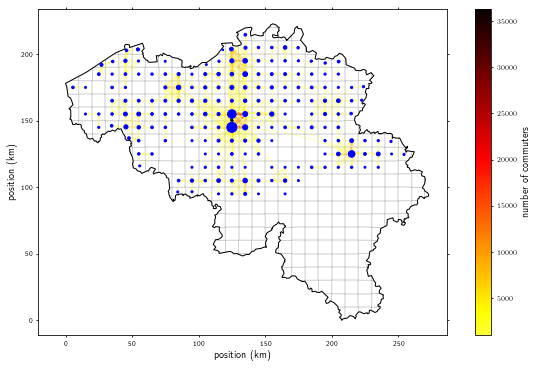

In [169]:
cell_plot_mobility = (
    cell_mobility.groupby(['from_cell_id', 'to_cell_id'])[['cell_count']]
                 .sum()
                 .reset_index()
                 .rename(columns={'cell_count': 'whole_ratio', 
                                  'from_cell_id': 'cell_id'}))
og_cmap = plt.get_cmap('hot').reversed()
edge_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', og_cmap(np.linspace(0.2, 1, 200)))
save_path = os.path.join(
    fig_dir, cc, 'networks',
    f'mobility_network_{area_name}_cell_size={cell_size}m.pdf')
ax = net_viz.plot_cell_interactions(
    cell_plot_mobility, cells_in_area_df, shape_df,
    edge_th=1000, save_path=save_path, edge_cmap=edge_cmap,
    cbar_label='number of commuters')

In [170]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
rescale_df = (cell_mobility.groupby('from_cell_id')['cell_count']
                           .sum()
                           .rename('local_count')
                           .to_frame())
cell_plot_df = mobility.rescale_data(
    cell_plot_df, rescale_df, plot_lings_dict, min_local_count=5)
rescaled_df = mobility.rescale_data(
    cell_plot_df, rescale_df, plot_lings_dict, min_local_count=5)
cell_mobility = mobility.commut_by_grp(cell_mobility, cell_plot_df, 
                                       plot_lings_dict)
user_dict = mobility.get_user_dict(cell_mobility, plot_lings_dict)
nr_users = len(user_dict['ling'])
user_df = pd.DataFrame(user_dict)
user_df['ling'] = user_df['ling'].astype('category')
print(user_df.shape)
user_df.head()

We lost 46635 commuters out of 3996312 because of holes in cell_plot_df
(3949677, 3)


,ling,res_cell_id,work_cell_id
0,ling_fr,15,14
1,ling_fr,15,14
2,ling_fr,15,14
3,ling_fr,15,14
4,ling_fr,15,14


 ### IPF tests

In [381]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
rescale_df = (cell_mobility.groupby('from_cell_id')['cell_count']
                           .sum()
                           .rename('local_count')
                           .to_frame())
rescaled_df = mobility.rescale_data(
    cell_plot_df, rescale_df, plot_lings_dict, min_local_count=5)

In [402]:
count_ling_cols = [ling_dict['count_col']
                       for ling_dict in plot_lings_dict.values()]
scaling_factors = rescaled_df[count_ling_cols] / cell_plot_df[count_ling_cols]
scaling_factors['local_count_rescale'] = rescale_df['local_count'] / cell_plot_df['local_count']
scaling_factors['local_count'] = rescale_df['local_count']

In [411]:
og_N = cell_plot_df['local_count'].sum()
new_N = rescaled_df['local_count'].sum()
for ling in plot_lings_dict:
    twitter_ratio = cell_plot_df['count_'+ling].sum() / og_N
    new_ratio = rescaled_df['count_'+ling].sum() / new_N
    print(ling, plot_lings_dict[ling]['ratio'] / twitter_ratio)
    print(twitter_ratio,
          plot_lings_dict[ling]['ratio'], new_ratio)

ling_fr 0.9728887577456475
0.32891735817925954 0.32 0.32000267117457915
ling_nl 0.897167092028224
0.6464793516766147 0.58 0.5799972984231302
ling_frnl 4.064497041420119
0.024603290144125784 0.10000000000000003 0.10000003040229073


In [403]:
scaling_factors.loc[scaling_factors['local_count_rescale'].notnull()].sort_values(by='local_count').tail(40)

,count_ling_fr,count_ling_nl,count_ling_frnl,local_count_rescale,local_count
cell_id,,,,,
111,45.005033,57.341887,262.100848,60.847503,23515.0
267,112.466628,143.296166,654.984492,162.324833,23596.0
217,91.670804,116.799756,533.873524,92.858116,23653.0
453,78.599194,100.144935,457.746927,105.135255,25013.0
308,176.452895,224.822454,1027.628478,183.225834,25666.0
129,40.316912,51.368650,234.798113,54.757996,25919.0
271,50.658019,64.544479,295.022779,67.518557,26226.0
269,104.534607,133.189805,608.789891,152.914142,26526.0
292,81.549066,103.903430,474.926425,116.741350,26531.0


## Iterate models

In [115]:
import sys
import logging
import logging.config
import traceback
import IPython

# logger = logging.getLogger(__name__)
# load config from file
logging.config.fileConfig('logging.ini', disable_existing_loggers=False)

def showtraceback(self):
    traceback_lines = traceback.format_exception(*sys.exc_info())
    del traceback_lines[1]
    message = ''.join(traceback_lines)
    logging.error(message)
#     sys.stderr.write(message)
IPython.core.interactiveshell.InteractiveShell.showtraceback = showtraceback

### Abrams-Strogatz model

In [223]:
user_df = pd.DataFrame(user_dict)
user_df = user_df.loc[user_df['ling'] != 'ling_frnl']
user_df['ling'] = user_df['ling'].astype('category')
model_dict = models_dict['AS']
hist_cell_df = None
prestige_A = None #{'res': 0.5, 'work': 0.5}
params = {'a': 0.5, 'rate': 1}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model=model_dict['short_name'], params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)

In [ ]:
t_steps = 1000
user_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
    user_df, cells_in_area_df, model_dict['fun'], lings, t_steps,
    prestige_A=prestige_A, simu_step_file_format=simu_step_file_format,
    hist_cell_df=hist_cell_df, **params)

2020-06-05 16:51:32,767 - src.models.lang_abm - INFO - ling
ling_fr    1377361
ling_nl    2219674
dtype: int64
2020-06-05 16:51:32,939 - src.models.lang_abm - INFO - * step 200 *
2020-06-05 16:51:35,697 - src.models.lang_abm - INFO - ling
ling_fr    1377474
ling_nl    2219561
dtype: int64
2020-06-05 16:51:38,429 - src.models.lang_abm - INFO - ling
ling_fr    1378308
ling_nl    2218727
dtype: int64
2020-06-05 16:51:38,431 - src.models.lang_abm - INFO - * step 201 *
2020-06-05 16:51:40,983 - src.models.lang_abm - INFO - ling
ling_fr    1379825
ling_nl    2217210
dtype: int64


s(x), a=0.5, rate=1 => separate regions

s=0.5, a=1, rate=1 => uniform, very slow to go extinct

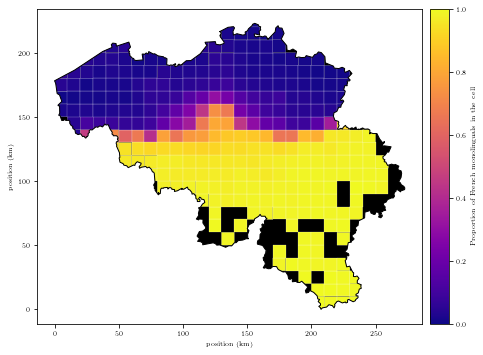

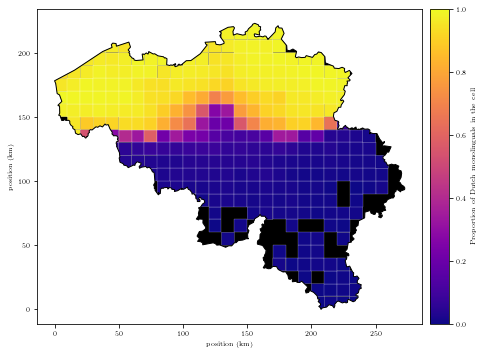

In [175]:
# new_cell_df = hist_cell_df[2399]
new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=100)).join(
    cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_frnl'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='{grp}_')
# fig_save_path_format = None
figsize = (plt.rcParams["figure.figsize"][0]*2, plt.rcParams["figure.figsize"][0]*2)
helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k', figsize=figsize)

s(x), a=1, rate=1 => separate regions

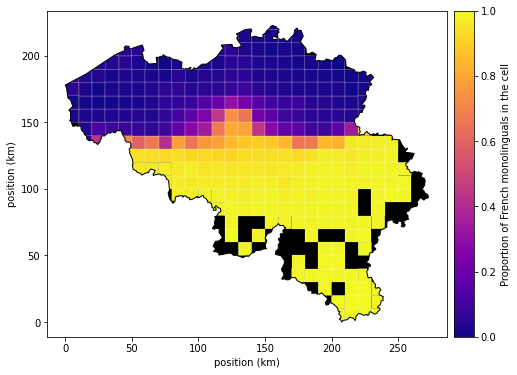

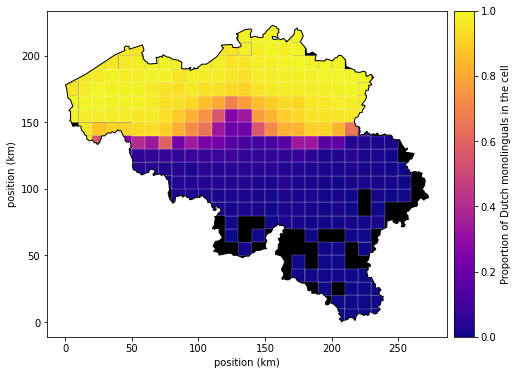

In [1093]:
new_cell_df = hist_cell_df[100]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=100)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_frnl'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

s=0.5, a=0.5, rate=1 => uniformisation

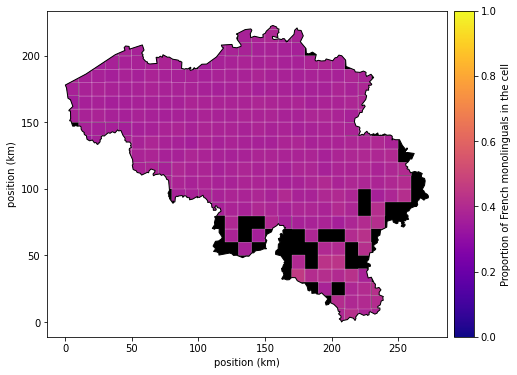

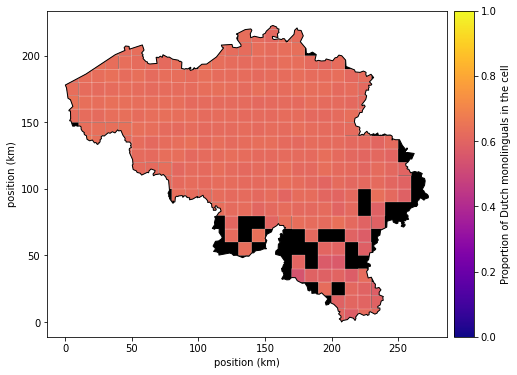

In [1088]:
new_cell_df = hist_cell_df[100]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=100)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_frnl'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

### Bilingual model

In [71]:
model_dict = models_dict['bi_pref']
prestige_A = {'res': 0.5, 'work': 0.5}
params = {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.005, 'q': 0.5}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model=model_dict['short_name'],
    params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)
    
# user_df = pd.DataFrame(user_dict)
# user_df['ling'] = user_df['ling'].astype('category')
# hist_cell_df = None

0 to 2200: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.005, 'q': 0.5}

2201 to 2600: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.006, 'q': 0.5}

2600 to 3000: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.007, 'q': 0.5}

3000 to 3400: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.008, 'q': 0.5}

3400 to N: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.009, 'q': 0.5}

4000 to 4400: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.01, 'q': 0.5}

4400 to 4800: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.011, 'q': 0.5}

4800 to 5200: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.012, 'q': 0.5}

5200 to 5600: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.013, 'q': 0.5}

5600 to 6000: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.014, 'q': 0.5}

6000 to 6400: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.015, 'q': 0.5}

6400 to 6800: {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.016, 'q': 0.5}

In [121]:
user_df = pd.read_csv('user_df.csv').drop(columns=['Unnamed: 0'])

In [95]:
t_steps = 200
user_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
    user_df, cells_in_area_df, model_dict['fun'], lings, t_steps,
    prestige_A=prestige_A, simu_step_file_format=simu_step_file_format,
    hist_cell_df=hist_cell_df, **params)

2020-11-11 17:04:41,337 - src.models.lang_abm - INFO - ling
ling_fr       898597
ling_frnl     272560
ling_nl      2778716
dtype: int64
2020-11-11 17:04:41,524 - src.models.lang_abm - INFO - * step 4000 *
2020-11-11 17:04:45,054 - src.models.lang_abm - INFO - ling
ling_fr       898409
ling_frnl     272628
ling_nl      2778836
dtype: int64
2020-11-11 17:04:48,558 - src.models.lang_abm - INFO - ling
ling_fr       898152
ling_frnl     272781
ling_nl      2778940
dtype: int64
2020-11-11 17:04:48,561 - src.models.lang_abm - INFO - * step 4001 *
2020-11-11 17:04:51,992 - src.models.lang_abm - INFO - ling
ling_fr       898065
ling_frnl     272767
ling_nl      2779041
dtype: int64
2020-11-11 17:04:55,516 - src.models.lang_abm - INFO - ling
ling_fr       897853
ling_frnl     272830
ling_nl      2779190
dtype: int64
2020-11-11 17:04:55,520 - src.models.lang_abm - INFO - * step 4002 *
2020-11-11 17:04:58,969 - src.models.lang_abm - INFO - ling
ling_fr       897682
ling_frnl     272958
ling_nl    

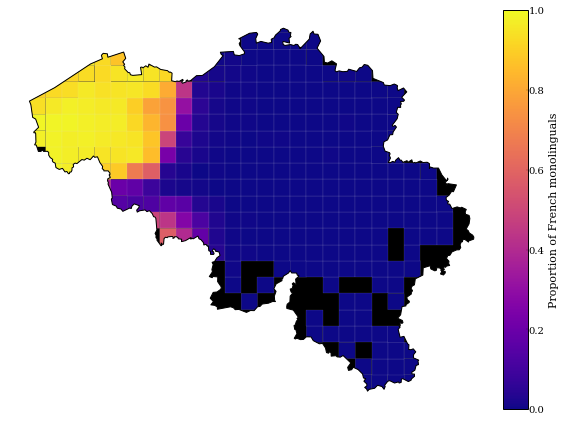

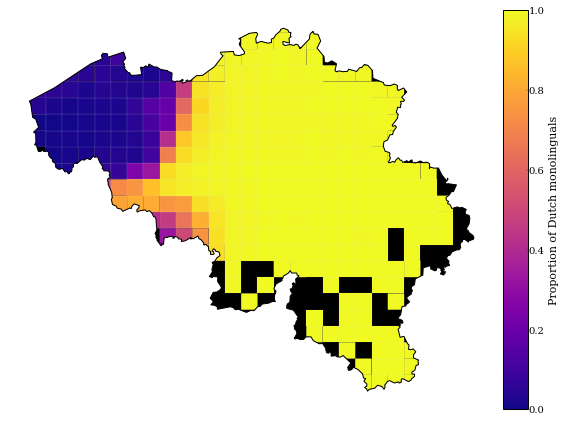

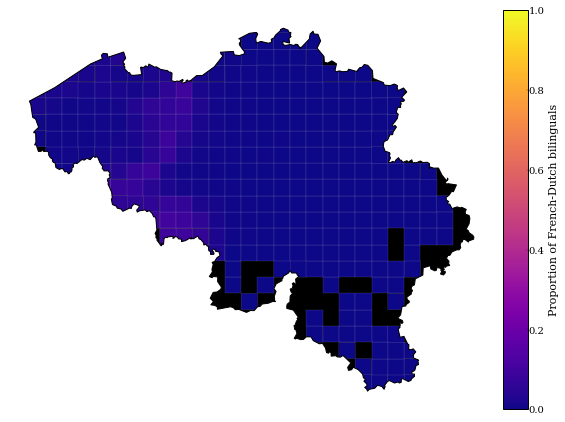

In [268]:
new_cell_df = hist_cell_df[-1]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=12000)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
new_cell_df, plot_lings_dict = metrics.calc_by_cell(
    new_cell_df, plot_lings_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [171]:
x_data = np.arange(1, 23400, 1)
nr_users = user_df.shape[0]
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
# append_from = (len(hist_cell_df)-len(ling_props_dict['French monolinguals']))
# append_from = 23400
for t_step in x_data:
    cell_counts_df = pd.read_csv(simu_step_file_format.format(t_step=t_step),
                                 usecols=count_cols)
#     cell_counts_df = hist_cell_df[t_step]
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

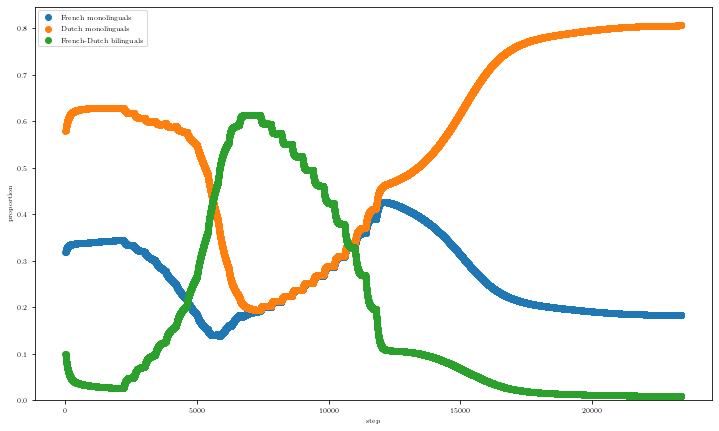

In [234]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='sep_to_mix_to_sep_')
# fig_save_path = None
idx_data_to_plot = np.arange(0, len(x_data), 1)
figsize = (10,6) #(plt.rcParams["figure.figsize"][0], plt.rcParams["figure.figsize"][1])
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=[0, 1, 2], figsize=figsize, bottom_ylim=0,
    fig_save_path=fig_save_path, show=True)

In [22]:
x_data = np.arange(1, 15000, 1)
nr_users = len(user_dict['ling'])
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
for t_step in x_data:
    cell_counts_df = pd.read_csv(simu_step_file_format.format(t_step=t_step),
                                 usecols=count_cols)
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

In [382]:
Hp_dict = {'name': 'Hp', 'readable': 'Relative proportion entropy', 
           'scale_fun': metrics.null_Hp, 'log_scale': False,
           'total_count_col': 'local_count', 'sym_about': 1}

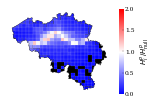

In [395]:
final_state_df = pd.read_csv(simu_step_file_format.format(t_step=x_data[-1]))
final_state_df = cells_in_area_df.join(final_state_df.set_index('res_cell_id'), how='inner')
final_state_df = metrics.lang_counts_from_ling(
    final_state_df, plot_langs_dict, plot_lings_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
grps_dict = plot_multi_mono_dict
count_col = 'multi_count'
final_state_df[count_col] = 0
for ling, ling_dict in plot_lings_dict.items():
    if len(ling.split('_')[1]) > 2:
        final_state_df[count_col] += final_state_df[ling_dict['count_col']]
final_state_df, grps_dict = metrics.calc_by_cell(
    final_state_df, grps_dict, cell_size=cell_size)
mono_multi_lings_dict = {'mono-multi': {'grp_label': 'mono/bi-linguals'}}
metric_dict = Hp_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
cbar_label = r'$H_i^p / H_{\mathrm{null}}^p$'
figsize = (16.8/3/2.54, 10)
helpers_viz.metric_grid(
    final_state_df, metric_dict, shape_df, grps_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0, cbar_label=cbar_label)

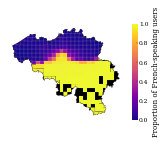

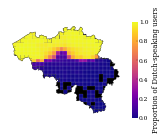

In [398]:
metric_dict = prop_dict
metric = metric_dict['name']
grps_dict = plot_langs_dict
final_state_df, grps_dict = metrics.calc_by_cell(
    final_state_df, grps_dict, cell_size=cell_size)
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
figsize = (17.8/3/2.54, 10)
helpers_viz.metric_grid(
    final_state_df, metric_dict, shape_df, grps_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, borderwidth=0.2,
    min_count=5, null_color='k', figsize=figsize, cbar_lw=0)

/home/thomaslouf/Documents/code/multiling-twitter/src/visualization/helpers.py:336: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



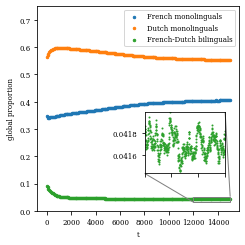

In [399]:
bbox_to_anchor = (0.55, 0.2, 0.4, 0.3)
figsize = (8.7 / 2.54, 8.7 / 2.54)
fig, ax = sim_viz.scatter_inset(
    x_data, ling_props_dict, bbox_to_anchor, (12000, 15000), 2, save_path='haha.pdf',
    figsize=figsize, ax=None, fig=None, color_cycle=None, top_ylim=0.75, 
    inset_left=True)

Minett: more bilinguals until a point, then it starts declining

In [ ]:
x_data = np.arange(1, 600, 1)
nr_users = len(user_dict['ling'])
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
for t_step in x_data:
    cell_counts_df = pd.read_csv(simu_step_file_format.format(t_step=t_step),
                                 usecols=count_cols)
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

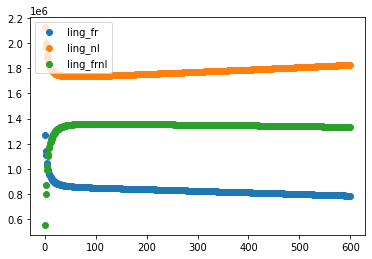

In [154]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

### Video of border breaking

In [333]:
from matplotlib.collections import PatchCollection
import matplotlib.cm
from matplotlib import animation
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [247]:
t_steps = np.arange(1, 23000, 100)
list_step_polars = []
for t in t_steps:
    step_df = pd.read_csv(simu_step_file_format.format(t_step=t))
    if 'Unnamed: 0' in step_df.columns:
        step_df = step_df.rename(columns={'Unnamed: 0': 'res_cell_id'})
    step_df = geopd.GeoDataFrame(step_df.join(cells_in_area_df[['geometry']],
                                       on='res_cell_id'),
                                 crs=cells_in_area_df.crs)
    step_df, _ = metrics.calc_by_cell(step_df, plot_lings_dict, cell_size=cell_size)
    step_df['fr_polar'] = 0.5 * (1 + step_df['prop_ling_fr'] - step_df['prop_ling_nl'])
    list_step_polars.append(step_df)

In [239]:
def fun_c_value(step, start_inc=2200, start_dec=7200, inter=400, nr_inc=10):
    c = 0.005
    end_inc = start_inc + inter*(nr_inc-1)
    end_dec = start_dec + inter*(nr_inc-1)
    if step > start_inc:
        c += (1 + (min(step, end_inc) - start_inc) // inter) * 0.005
    if step > start_dec:
        c -= (1 + (min(step, end_dec) - start_dec) // inter) * 0.005
    return c

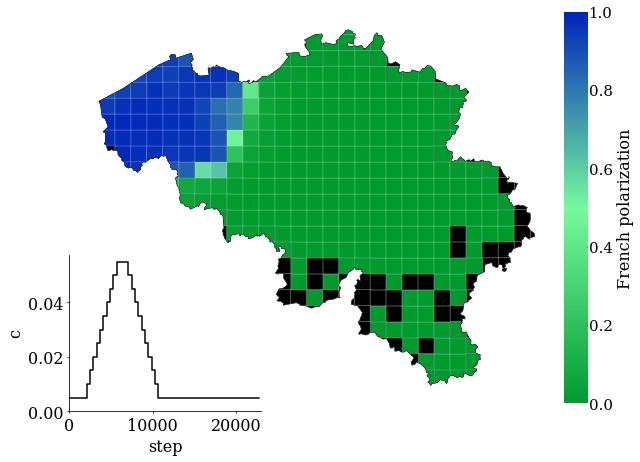

In [335]:
plt.rc('font', size=16)
plt.rc('text', usetex=False)
fig, ax = plt.subplots(1, figsize=(1280/100, 720/100))
step_df = list_step_polars[0]
cbar_label = 'French polarization'
cmap = colors.LinearSegmentedColormap.from_list('my_cmap', conv_kinds_c[[0, 1, 3]])
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.2, 'cmap': cmap}
fig, ax = grid_viz.plot_grid(
    step_df, shape_df, metric_col='fr_polar', ax=ax, fig=fig,
    cbar_label=cbar_label, cbar_lw=0, vmin=0, vmax=1,# cax=cax_maps,
    show_axes=False, borderwidth=0.5, tight_layout=False,
    **{'plot': plot_kwargs})
for c in ax.get_children():
    if isinstance(c, PatchCollection):
        ec = c.get_ec()
        if len(ec) > 0:
            if np.all(ec[0,:-1] == np.asarray(plot_kwargs['edgecolor'])):
                collec = c
collec = [c for c in ax.get_children() ][1]
# Beware this was completely changed in posterior versions of geopandas:
geoms, multiindex = geopd.plotting._flatten_multi_geoms(step_df.geometry, range(len(step_df.geometry)))


axins = inset_axes(ax, width='100%', height='100%',
                   bbox_to_anchor=(0, 0, 0.4, 0.4),
                   bbox_transform=ax.transAxes)
c_evol_values = [fun_c_value(t) for t in t_steps]
line, = axins.step(t_steps, c_evol_values, color='k')
axins.set_xlabel('step')
axins.set_ylabel('c')
axins.set_xlim(0, 23000)
axins.set_ylim(bottom=0)
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)
# step_text = ax.annotate('step 1', (0, -0.05), xycoords='axes fraction')

def animate(i, t_steps, list_step_polars, multiindex, c_evol_values):
#     step = t_steps[i]
    collec.set_array(list_step_polars[i]['fr_polar'].values[multiindex])
#     step_text.set_text(f'step {step}\n c = {fun_c_value(step):.2g}')
    line.set_data(t_steps[:i], c_evol_values[:i])
    return collec, line #, step_text

# fig.tight_layout()
anim_args = np.arange(len(list_step_polars))
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, anim_args, fargs=[t_steps, list_step_polars, multiindex, c_evol_values],
                               interval=100, blit=True, repeat=False)
anim.save('BE_borders.gif', dpi=200)

### Numerical stability

sum_nu_rows = 1

With mock data in two cells

In [874]:
mock_users_df = pd.DataFrame({
    'ling': 500*['ling_fr', 'ling_nl'],
    'res_cell_id': 500*[14]+500*[15],
    'work_cell_id': 400*[14]+100*[15]+400*[15]+100*[14]})
# mock_users_df['ling'] = mock_users_df['ling'].astype('category')
model_dict = models_dict['bi_pref']
hist_cell_df = None
prestige_A = {'res': 0.5, 'work': 0.5}
params = {'a': 1, 'rate': 1, 'q': 0.5, 'mu': 0.02, 'c': 0.05}
mock_N = np.array((500,500))
mock_nu = np.array([[0.8, 0.2], [0.2, 0.8]])
mock_nu_T_N = np.dot(mock_nu.T, mock_N)

SOlution with RK solver

In [875]:
mock_N_L_init = np.array((250,250,250,250))
bi_pref_system_to_int = lambda t, N_L: metapop.bi_pref_system(N_L, mock_N, mock_nu, mock_nu_T_N, **params)
result = scipy.integrate.solve_ivp(bi_pref_system_to_int, (0, 1000), mock_N_L_init)

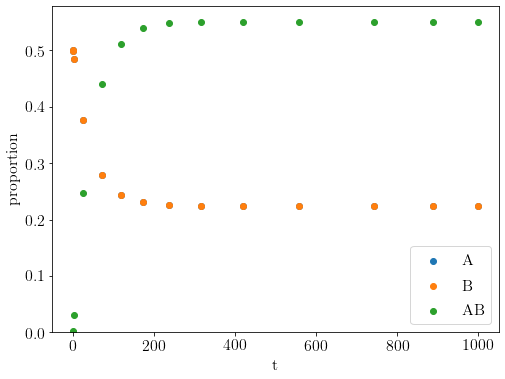

In [879]:
A_global_evol = np.sum(result.y[:mock_N.shape[0],:], axis=0)
B_global_evol = np.sum(result.y[mock_N.shape[0]:,:], axis=0)
total_pop = mock_N.sum()
ling_props_dict = {'A': A_global_evol / total_pop,
                   'B': B_global_evol / total_pop,
                   'AB': 1 - (A_global_evol + B_global_evol) / total_pop}
idx_data_to_plot = np.arange(0, len(result.t), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, result.t, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

Solution from simu

In [832]:
t_steps = 40
mock_users_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
    mock_users_df, cells_in_area_df.iloc[[0,1]], model_dict['fun'], lings, t_steps,
    prestige_A=prestige_A, simu_step_file_format=None,
    hist_cell_df=hist_cell_df, **params)

2020-09-24 12:02:51,194 - src.models.lang_abm - INFO - ling
ling_fr      946
ling_frnl     54
dtype: int64
2020-09-24 12:02:51,203 - src.models.lang_abm - INFO - * step 160 *
2020-09-24 12:02:51,270 - src.models.lang_abm - INFO - ling
ling_fr      946
ling_frnl     54
dtype: int64
2020-09-24 12:02:51,329 - src.models.lang_abm - INFO - ling
ling_fr      946
ling_frnl     54
dtype: int64
2020-09-24 12:02:51,331 - src.models.lang_abm - INFO - * step 161 *
2020-09-24 12:02:51,392 - src.models.lang_abm - INFO - ling
ling_fr      946
ling_frnl     54
dtype: int64
2020-09-24 12:02:51,453 - src.models.lang_abm - INFO - ling
ling_fr      946
ling_frnl     54
dtype: int64
2020-09-24 12:02:51,454 - src.models.lang_abm - INFO - * step 162 *
2020-09-24 12:02:51,516 - src.models.lang_abm - INFO - ling
ling_fr      948
ling_frnl     52
dtype: int64
2020-09-24 12:02:51,580 - src.models.lang_abm - INFO - ling
ling_fr      950
ling_frnl     50
dtype: int64
2020-09-24 12:02:51,582 - src.models.lang_abm -

In [860]:
x_data = np.arange(0, len(hist_cell_df), 1)
nr_users = mock_users_df.shape[0]
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
for t_step in x_data:
    cell_counts_df = hist_cell_df[t_step][count_cols]
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

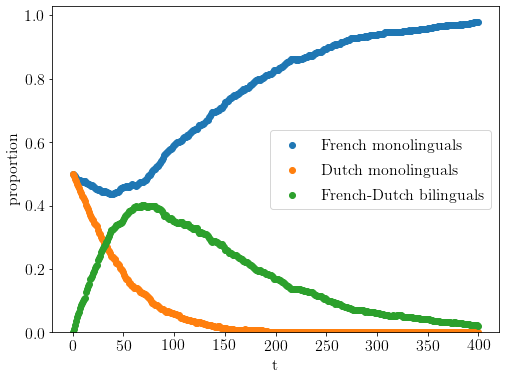

In [864]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

Solution Belgium

In [40]:
tau = 2
nu, N, df_to_mat_idx = mobility.df_to_nu(cell_mobility, tau=tau)
nu_T_N = np.dot(nu.T, N)

In [41]:
# params = {'s': 0.5, 'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.01, 'q': 0.5} # {'s': 0.5, 'a': 1, 'rate': 0.2}
params = {'s': 0.5, 'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.01, 'q': 0.5}
params_str = '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model='bi_pref',
    params=params_str, t_step='{t_step}')

In [42]:
# ling_counts = pd.read_csv(simu_step_file_format.format(t_step=1))
ling_counts = cell_plot_df
N_L = np.concatenate((ling_counts['count_ling_fr'].values, ling_counts['count_ling_nl'].values))

RK solution

In [43]:
import scipy.integrate

In [44]:
# ling_counts = pd.read_csv(simu_step_file_format.format(t_step=1))
ling_counts = cell_plot_df
N_L_init = np.concatenate((ling_counts['count_ling_fr'].values, ling_counts['count_ling_nl'].values))
bi_pref_system_to_int = lambda t, N_L: metapop.bi_pref_system(N_L, N, nu, nu_T_N, **params)

In [47]:
result = scipy.integrate.solve_ivp(bi_pref_system_to_int, (0, 100000), N_L_init)

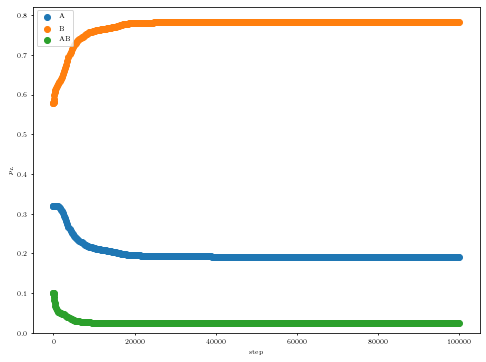

In [48]:
A_global_evol = np.sum(result.y[:N.shape[0],:], axis=0)
B_global_evol = np.sum(result.y[N.shape[0]:,:], axis=0)
total_pop = N.sum()
ling_props_dict = {'A': A_global_evol / total_pop,
                   'B': B_global_evol / total_pop,
                   'AB': 1 - (A_global_evol + B_global_evol) / total_pop}
idx_data_to_plot = np.arange(0, len(result.t), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, result.t, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

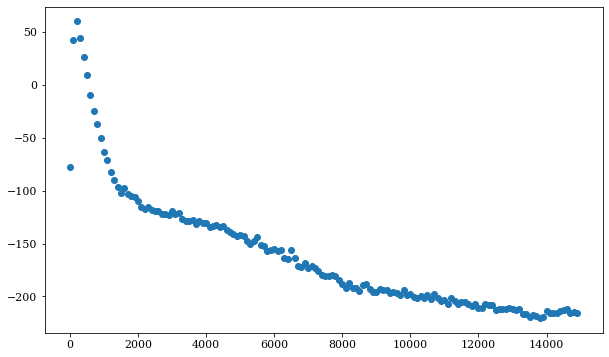

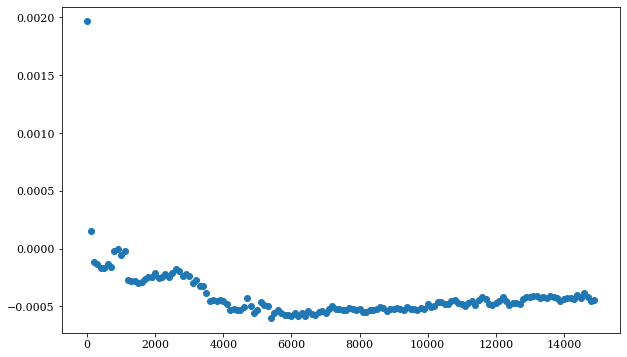

In [243]:
x_plot = range(1, 15000, 100)
y_plot_derivA = []
y_plot_derivB = []
y_plot_max_eigen = []
for t_step in x_plot:
    ling_counts = pd.read_csv(simu_step_file_format.format(t_step=t_step))
    N_L_t = np.array(list(ling_counts['count_ling_fr'].values) + list(ling_counts['count_ling_nl'].values))
    deriv = metapop.bi_pref_system(N_L_t, N, nu, nu_T_N, **params)
    derivA = deriv[:N.shape[0]]
    derivB = deriv[N.shape[0]:]
    y_plot_derivA.append(np.sum(derivA))
    y_plot_derivB.append(np.sum(derivB))
    jacobian = metapop.bi_pref_jacobian(N_L_t, N, nu, nu_T_N, **params)
    jac_eigen, _ = eig(jacobian)
    y_plot_max_eigen.append(np.max(jac_eigen.real))
plt.scatter(x_plot, y_plot_derivA)
plt.show()

plt.scatter(x_plot, y_plot_max_eigen)
plt.show()

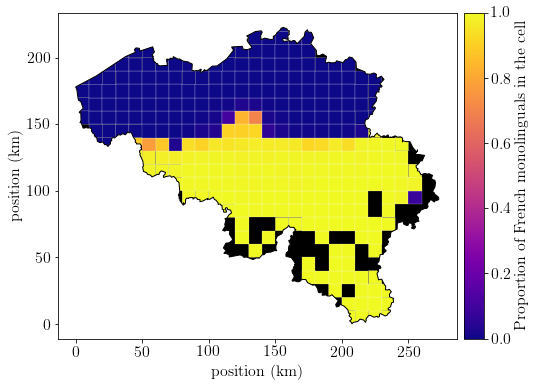

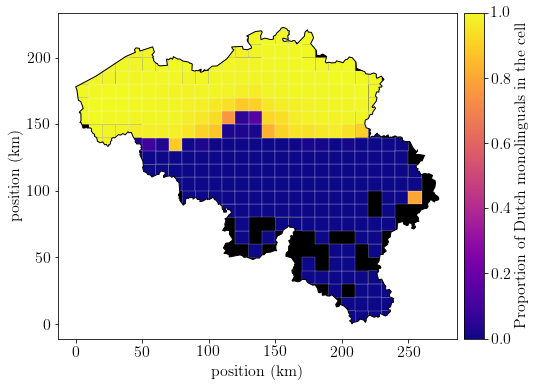

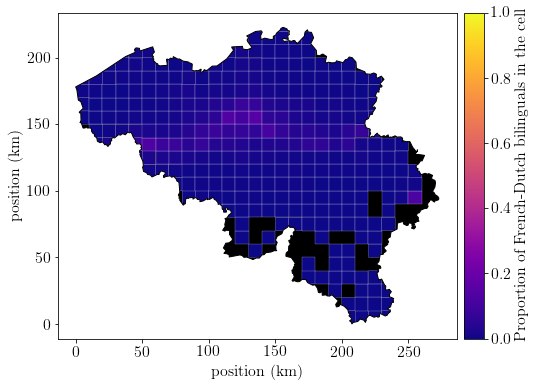

In [734]:
# new_cell_df = hist_cell_df[20]
new_cell_df = cells_in_area_df[['geometry']]
index_simu_data = list(df_to_mat_idx.keys())
new_cell_df = new_cell_df.join(pd.Series(result.y[:N.shape[0], -1], index=index_simu_data, name='count_ling_fr'))
new_cell_df = new_cell_df.join(pd.Series(result.y[N.shape[0]:, -1], index=index_simu_data, name='count_ling_nl'))
new_cell_df = new_cell_df.join(pd.Series(N, index=index_simu_data, name='total_count'))
new_cell_df = new_cell_df.join(pd.Series(N, index=index_simu_data, name='local_count'))
non_geo_cols = [col for col in new_cell_df.columns if col != 'geometry']
new_cell_df[non_geo_cols] = new_cell_df[non_geo_cols].fillna(0)
new_cell_df['count_ling_frnl'] = (new_cell_df['local_count']
                                  - new_cell_df['count_ling_nl']
                                  - new_cell_df['count_ling_fr'])
new_cell_df, plot_lings_dict = metrics.calc_by_cell(
    new_cell_df, plot_lings_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

ABM vs RK

In [18]:
nr_steps_avg = 1000
simu_ling_counts = pd.read_csv(simu_step_file_format.format(t_step=15000),
                               index_col='res_cell_id')
count_cols = [col for col in simu_ling_counts.columns]
for k in range(1, nr_steps_avg):
    simu_ling_counts[count_cols] += pd.read_csv(
        simu_step_file_format.format(t_step=15000-k), index_col='res_cell_id')
simu_ling_counts[count_cols] /= nr_steps_avg

In [19]:
ling_counts = pd.read_csv(simu_step_file_format.format(t_step=1),
                          index_col='res_cell_id')
N_L_init = np.concatenate((ling_counts['count_ling_fr'].values, ling_counts['count_ling_nl'].values))
bi_pref_system_to_int = lambda t, N_L: metapop.bi_pref_system(N_L, N, nu, nu_T_N, **params)
result = scipy.integrate.solve_ivp(bi_pref_system_to_int, (0, 15000), N_L_init)

In [20]:
int_ling_counts = ling_counts.copy()
int_ling_counts['count_'+lings[0]] = result.y[:N.shape[0], -1]
int_ling_counts['count_'+lings[1]] = result.y[N.shape[0]:, -1]
int_ling_counts['count_'+lings[2]] = (N - result.y[:N.shape[0], -1] 
                                      - result.y[N.shape[0]:, -1])

In [21]:
comp_df = int_ling_counts.join(simu_ling_counts, lsuffix='_int', rsuffix='_abm')
comp_df = geopd.GeoDataFrame(comp_df, geometry=cells_in_area_df['geometry'],
                             crs=cells_in_area_df.crs)
comp_df.head()

,count_ling_fr_int,count_ling_frnl_int,count_ling_nl_int,local_count_int,total_count_int,count_ling_fr_abm,count_ling_frnl_abm,count_ling_nl_abm,local_count_abm,total_count_abm,geometry
res_cell_id,,,,,,,,,,,
15,0.142257,11.445267,3835.412476,3847,3847,19.261,23.025,3804.714,3847.0,3847.0,"POLYGON ((525928.736 681203.386, 532304.370 68..."
16,0.020735,2.976810,1780.002456,1783,1783,5.178,10.065,1767.757,1783.0,1783.0,"POLYGON ((524017.058 691203.386, 532304.370 69..."
17,1.857518,58.899934,7779.242548,7840,7840,126.174,143.275,7570.551,7840.0,7840.0,"POLYGON ((525975.405 701203.386, 532304.370 70..."
18,0.779500,17.206406,1582.014094,1600,1600,45.153,49.744,1505.103,1600.0,1600.0,"POLYGON ((532304.370 704575.186, 532304.370 70..."
36,0.004291,0.640635,398.355074,399,399,1.213,1.231,396.556,399.0,399.0,"POLYGON ((538045.774 661203.386, 542304.370 66..."


In [38]:
d_matrix = None
# comp_df['total_conc'] = 1 / comp_df.shape[0]
comp_df['total_conc'] = comp_df['total_count_int'] / comp_df['total_count_int'].sum()
for ling, ling_dict in plot_lings_dict.items():
    abm_count_col = 'count_' + ling + '_abm'
    int_count_col = 'count_' + ling + '_int'
    comp_df[abm_count_col] = comp_df[abm_count_col].fillna(0)
    comp_df[int_count_col] = comp_df[int_count_col].fillna(0)
    obs_col = 'conc_' + ling + '_abm'
    pred_col = 'conc_' + ling + '_int'
    comp_df[obs_col] = comp_df[abm_count_col] / comp_df[abm_count_col].sum()
    comp_df[pred_col] = comp_df[int_count_col] / comp_df[int_count_col].sum()
    print(ling)
    try:
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            comp_df, obs_col, pred_col, d_matrix=d_matrix)
        print(emd_value, emd_value / norm)
    except:
        print(sys.exc_info())

ling_fr
3231.679502613309 0.042919910840816866
ling_nl
1840.601698911295 0.024445017133303736
ling_frnl
6476.607350298201 0.08601577285154427


In [40]:
nr_steps_avg = 2000
all_N_L = np.zeros((nr_steps_avg, N.shape[0]*2))
for k in range(nr_steps_avg):
    ling_counts = pd.read_csv(simu_step_file_format.format(t_step=15000-k))
    all_N_L[nr_steps_avg-k-1] = np.array(list(ling_counts['count_ling_fr'].values) + list(ling_counts['count_ling_nl'].values))
N_L_avg = np.mean(all_N_L, axis=0)
# p_L /= len(p_L)

In [41]:
np.mean(np.abs(metapop.bi_pref_system(N_L_avg, N, nu, nu_T_N, **params)))

0.7352815476132226

ABM time evol of derivatives

In [424]:
x_plot = range(1, 15000, 100)
y_plot = []
for t_step in x_plot:
    ling_counts = pd.read_csv(simu_step_file_format.format(t_step=t_step))
    N_L_t = np.array(list(ling_counts['count_ling_fr'].values) + list(ling_counts['count_ling_nl'].values))
    y_plot.append(np.mean(np.abs(metapop.bi_pref_system(N_L_t, N, nu, nu_T_N, **params))))

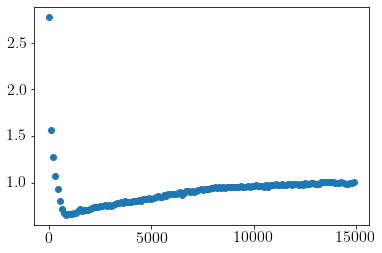

In [423]:
plt.scatter(x_plot, y_plot)

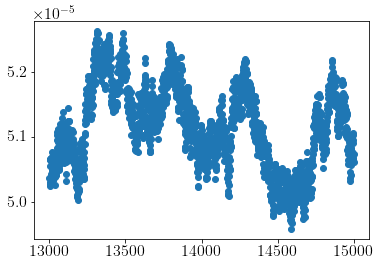

In [406]:
x_plot = range(15000-nr_steps_avg, 15000)
y_plot = [np.mean(np.abs(metapop.bi_pref_system(N_L_t, N, nu, nu_T_N, **params)) / np.tile(N, 2)) for N_L_t in all_N_L]
plt.scatter(x_plot, y_plot)

In [367]:
ling_counts = pd.read_csv(simu_step_file_format.format(t_step=1))
N_L = np.concatenate((ling_counts['count_ling_fr'].values, ling_counts['count_ling_nl'].values))

In [388]:
np.mean(np.abs(metapop.bi_pref_system(N_L_avg, N, nu, nu_T_N, **params)) / np.tile(N, 2))

4.9973193406537134e-05

Stability

In [235]:
def build_jacobian2(N_L, N, nu, nu_T_N, mu=0.02, c=0.1, s=0.5, q=0.5, a=1, rate=1):
    n_cells = N.shape[0]
    N_A = N_L[:n_cells]
    N_B = N_L[n_cells:]
    AA_block = np.zeros((n_cells, n_cells))
    for i in range(n_cells):
        sumsum = sum([nu[i,j] * np.sum((q*N_B - (1-q)*N_A)*nu[:,j]) / np.sum(N*nu[:,j]) for j in range(n_cells)])
        for l in range(n_cells):
            nu_sum = sum([nu[i,j] * nu[l,j] / np.sum(N*nu[:,j]) for j in range(n_cells)])
            AA_block[i,l] += mu*s*(1-q) * (N[i]-N_A[i]-N_B[i]) * nu_sum
            AA_block[i,l] += c*(1-mu)*(1-s)*(1-q) * N_A[i] * nu_sum
            if i == l:
                AA_block[i,l] += mu*s*(-q*np.sum(nu[i,:]) + sumsum)
                AA_block[i,l] += -c*(1-mu)*(1-s)*((1-q)*np.sum(nu[i,:]) + sumsum)
    return AA_block

In [44]:
from scipy.linalg import eig

In [45]:
jacobian = metapop.bi_pref_jacobian(N_L_avg, N, nu, nu_T_N, **params)
jac_eigen, _ = eig(jacobian)
print(np.all(jac_eigen.real < 0))

True


### EMD phase space exploration

In [65]:
conv_kinds_c = np.array([(0, 154, 47), (118, 250, 158), (10, 123, 123), (0, 37, 186)]) / 255

In [181]:
d_matrix = None
emd_langs = []
emd_lings = []
emd_multi = []
steps = np.array((1, 100, 1000, 2200, 4000, 5000, 6000, 6480, 7000, 8000, 9000, 10000,
                  12000, 13000, 14000, 15000, 17000, 23000))
for step in steps:
    step_df = pd.read_csv(simu_step_file_format.format(t_step=step))
    if 'Unnamed: 0' in step_df.columns:
        step_df = step_df.rename(columns={'Unnamed: 0': 'res_cell_id'})
    new_cell_df = geopd.GeoDataFrame(step_df.join(cells_in_area_df[['geometry']],
                                           on='res_cell_id'),
                                     crs=cells_in_area_df.crs)
    real_cell_size = (new_cell_df.area)**0.5
    new_cell_df, plot_lings_dict = metrics.calc_by_cell(
        new_cell_df, plot_lings_dict, cell_size=real_cell_size)

    grps_dict = plot_langs_dict
    for lang in grps_dict:
        new_cell_df['count_'+lang] = 0
    for ling, ling_dict in plot_lings_dict.items():
        ling_count_col = ling_dict['count_col']
        langs = ling.split('_')[-1]
        langs = [langs[i*2:(i+1)*2] for i in range(len(langs) // 2)]
        for lang in langs:
            new_cell_df['count_'+lang] += new_cell_df[ling_count_col]
    new_cell_df, grps_dict = metrics.calc_by_cell(
        new_cell_df, grps_dict, cell_size=real_cell_size)
    N = sum([new_cell_df[f'count_{grp}'].sum() for grp in grps_dict])
    emd_langs.append(0)
    for grp, grp_dict in grps_dict.items():
        N_grp = new_cell_df[grp_dict['count_col']].sum()
        grp_label = grp_dict['grp_label']
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            new_cell_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
        emd_langs[-1] += N_grp/N * emd_value/norm
    
    grps_dict = plot_lings_dict
    N = sum([new_cell_df[f'count_{grp}'].sum() for grp in grps_dict if len(grp) == 7])
    emd_lings.append(0)
    for grp, grp_dict in plot_langs_dict.items():
        N_grp = new_cell_df[grp_dict['count_col']].sum()
        grp_label = grp_dict['grp_label']
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            new_cell_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
        emd_lings[-1] += N_grp/N * emd_value/norm

    grps_dict = plot_multi_mono_dict
    count_col = 'multi_count'
    new_cell_df[count_col] = 0
    for ling, ling_dict in plot_lings_dict.items():
        ling_count_col = ling_dict['count_col']
        if (len(ling.split('_')[1]) > 2 and 
                ling_count_col in new_cell_df.columns):
            new_cell_df[count_col] += new_cell_df[ling_count_col]
    new_cell_df, grps_dict = metrics.calc_by_cell(
        new_cell_df, grps_dict, cell_size=real_cell_size)
    emd_value, norm, d_matrix = metrics.earthmover_distance(
        new_cell_df, grps_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
    emd_multi.append(emd_value / norm)
    print(step, emd_langs[-1], emd_lings[-1], emd_multi[-1])

1 0.26938390268979995 0.328942130632166 0.12375208982532003
100 0.28973179663838744 0.3288506417561128 0.13221346017887534
1000 0.33369635626413696 0.35522145696589574 0.2503733964869745
2200 0.3475620775884563 0.3669714213058015 0.30605784951929005
4000 0.2898914480051792 0.39295536120215857 0.2517555721287135
5000 0.213568992123276 0.3704863438864534 0.16382730873002474
6000 0.059232870582519415 0.19399173493648814 0.026310905320577293
6480 0.015395409107100225 0.05979389146332946 0.0026654700354861484
7000 0.0021086320095421362 0.008822686740209284 0.0005448167277515534
8000 0.0005969945372566818 0.002203594551803345 0.0005666732863984586
9000 0.0006911082117358895 0.0022103382820676345 0.000863314717706114
10000 0.0018072906900070444 0.0044743188504593355 0.0008328722823538347
12000 0.04777301316558716 0.06045997084696347 0.005539910091230192
13000 0.11048016032597469 0.13635982103428357 0.020751950487945012
14000 0.21153996077765458 0.25448826090234233 0.07630983788657117
15000 0.

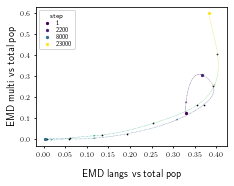

In [209]:
emd_langs = np.array(emd_langs)
emd_lings = np.array(emd_lings)
emd_multi = np.array(emd_multi)
fig, ax = plt.subplots(1)
arrow_steps = np.array([500, 6000, 9000, 11000, 12500, 18000])
stable_idc = np.in1d(steps, np.array((1, 2200, 8000, 23000)))
non_diff_pts = None #[0, 3, len(steps)]
fig, ax = sim_viz.scatter_interp(
    fig, ax, emd_lings, emd_multi, steps, stable_idc, arrow_steps,
    non_diff_pts=non_diff_pts, s=5)
ax.set_xlabel('EMD langs vs total pop')
ax.set_ylabel('EMD multi vs total pop')
ax.xaxis.labelpad = 0
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='emd_evol_')
fig.savefig(fig_save_path, bbox_inches='tight')
fig.show()

ValueError: 
\langle \textrm{EMR} \rangle_L
        ^
Unknown symbol: \textrm, found '\'  (at char 8), (line:1, col:9)

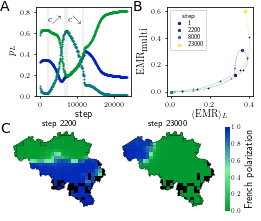

In [216]:
fig = plt.figure(figsize=(8.7/2.54, 7.3/2.54), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[1.2, 1])
gs_ax = gs[0].subgridspec(1, 2, width_ratios=[1.1, 1])
gs_axins = gs[1].subgridspec(1, 3, width_ratios=[100, 100, 5])
fig.set_constrained_layout_pads(w_pad=0/72, h_pad=0, wspace=0.05, hspace=0.1)
axes = gs_ax.subplots()
axinses = gs_axins.subplots()
cax_maps = axinses[2]

# Time evol
idx_data_to_plot = np.arange(0, len(x_data), 1)
axes[0] = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot[::50],
    idx_ling_to_plot=[0, 1, 2], ax=axes[0], bottom_ylim=0, show=False,
    color_cycle=conv_kinds_c[[3, 0, 2]], legend=False, s=1)
art = axes[0].annotate(annotations[0], (0, 0.95),
                       xycoords='figure fraction', **annotate_kwargs)
art.set_in_layout(False)
axes[0].annotate(r'$c$$\nearrow$', (2200, 0.7), fontsize=small_size+2)
axes[0].autoscale(False)
axes[0].plot([2200, 2200], [0, 1], ls=':', lw=0.3, c='k')
axes[0].plot([6600, 6600], [0, 1], ls=':', lw=0.3, c='k')
axes[0].annotate(r'$c$$\searrow$', (7400, 0.7), fontsize=small_size+2)
axes[0].plot([7200, 7200], [0, 1], ls=':', lw=0.3, c='k')
axes[0].plot([11600, 11600], [0, 1], ls=':', lw=0.3, c='k')

# EMD phase space
arrow_steps = np.array([500, 6000, 9000, 11000, 12500, 18000])
stable_idc = np.in1d(steps, np.array((1, 2200, 8000, 23000)))
fig, axes[1] = sim_viz.scatter_interp(fig, axes[1], emd_lings, emd_multi,
                                      steps, stable_idc, arrow_steps, s=5)
axes[1].set_xlabel(r'$\langle \textrm{EMR} \rangle_L$')
axes[1].set_ylabel(r'$\textrm{EMR}_{\textrm{multi}}$')
art = axes[1].annotate(annotations[1], (0.51, 0.95),
                       xycoords='figure fraction', **annotate_kwargs)
art.set_in_layout(False)
axes[0].xaxis.labelpad = 2
axes[1].xaxis.labelpad = 2

# Polarization maps
cbar_labels = (None, 'French polarization')
eg_steps = (2200, steps[-1])
cmap = colors.LinearSegmentedColormap.from_list('my_cmap', conv_kinds_c[[0, 1, 3]])
plot_kwargs = {'edgecolor': (0.9, 0.9, 0.9), 'linewidths': 0.01, 'cmap': cmap}
for i in range(2):
    step_df = pd.read_csv(simu_step_file_format.format(t_step=eg_steps[i]))
    if 'Unnamed: 0' in step_df.columns:
        step_df = step_df.rename(columns={'Unnamed: 0': 'res_cell_id'})
    step_df = geopd.GeoDataFrame(step_df.join(cells_in_area_df[['geometry']],
                                       on='res_cell_id'),
                                 crs=cells_in_area_df.crs)
    step_df, _ = metrics.calc_by_cell(step_df, plot_lings_dict, cell_size=cell_size)
    step_df['fr_polar'] = 0.5 * (1 + step_df['prop_ling_fr'] - step_df['prop_ling_nl'])
    fig, axinses[i] = grid_viz.plot_grid(
        step_df, shape_df, metric_col='fr_polar', ax=axinses[i], fig=fig,
        cbar_label=cbar_labels[i], cbar_lw=0, vmin=0, vmax=1, cax=cax_maps,
        show_axes=False, borderwidth=0.2, tight_layout=False,
        **{'plot': plot_kwargs})
    axinses[i].set_title(f'step {eg_steps[i]}', y=0.95)
art = axinses[0].annotate(annotations[2], (0, 0.4),
                          xycoords='figure fraction', **annotate_kwargs)
art.set_in_layout(False)
    
fig_save_path = os.path.join(fig_dir, cc, f'varying_c_sep_to_mix_to_sep.pdf')
fig.savefig(fig_save_path)
fig.show()

[0.3549856857174363] [0.24854699835014973]
[0.3549856857174363, 0.00564702641144043] [0.24854699835014973, 0.0004924655405818664]


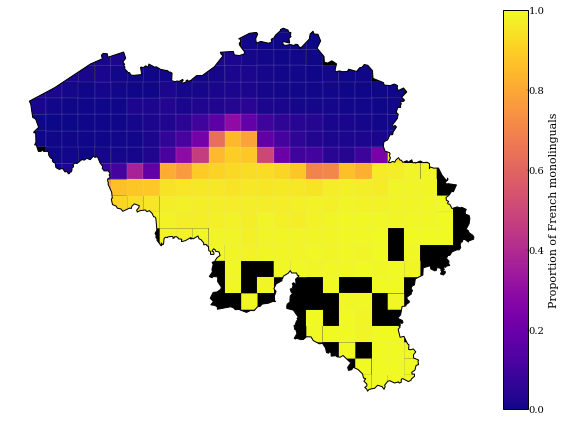

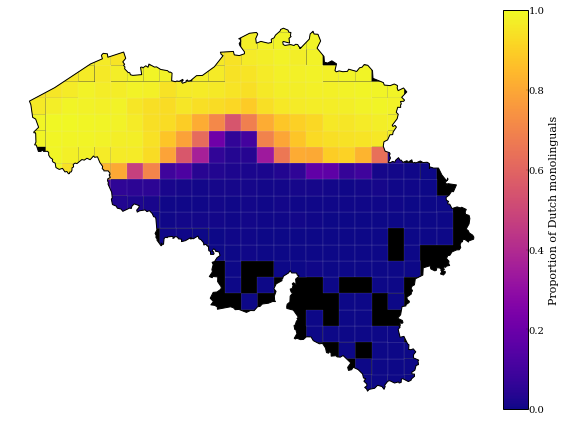

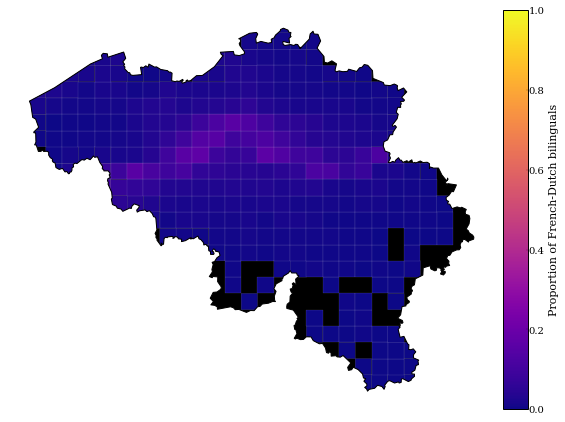

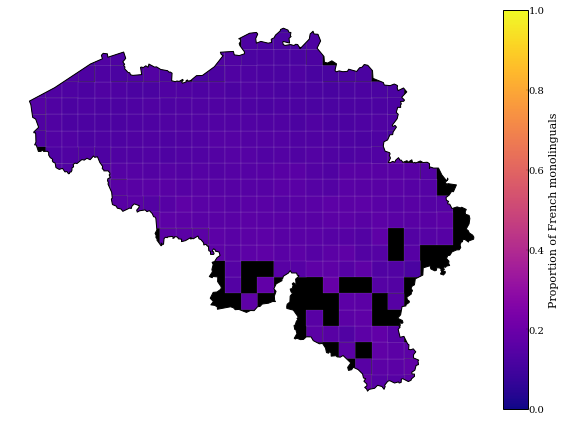

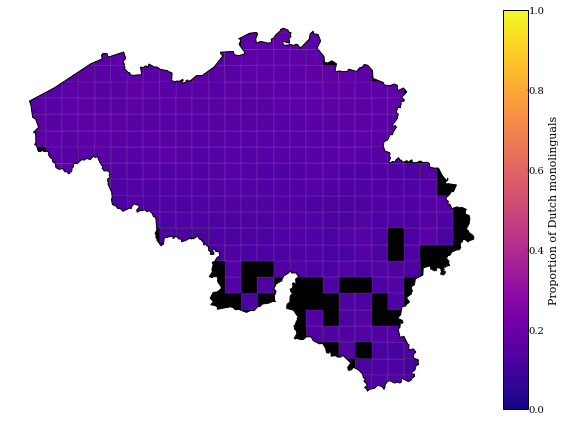

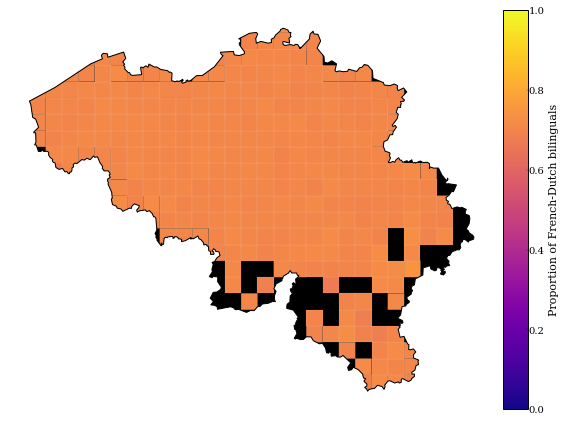

In [92]:
model_dict = models_dict['bi_pref']
hist_cell_df = None
# params = {'a': 1, 'rate': 0.2} #, 'mu': 0.02, 'c': 0.01, 'q': 0.5}
s = 0.5
list_params = [{'rate': 1, 'mu': 0.02, 'c': 0.01, 'q': 0.5},
               {'rate': 1, 'mu': 0.02, 'c': 0.1, 'q': 0.5}]
emd_langs = []
emd_multi = []
for i, extra_params in enumerate(list_params):
    d_matrix = None
    params = {'a': 1, **extra_params}
    params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
    simu_step_file_format = simu_res_file_format.format(
        cc=cc, cell_size=cell_size, model=model_dict['short_name'],
        params=params_str, t_step='{t_step}')
    simu_res_dir = os.path.split(simu_step_file_format)[0]
    pattern = re.compile(os.path.split(simu_step_file_format)[-1].replace('{t_step}', '([0-9]+)').replace('.', '\.'))
    t_steps = []
    for f in os.listdir(simu_res_dir):
        match = pattern.findall(f)
        if len(match) > 0:
            t_steps.append(int(match[0]))
    last_step = np.max(t_steps)
    new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=last_step)).join(
        cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
    real_cell_size = (new_cell_df.area)**0.5
    new_cell_df, plot_lings_dict = metrics.calc_by_cell(
        new_cell_df, plot_lings_dict, cell_size=real_cell_size)
    metric_dict = prop_dict
    metric = metric_dict['name']
    fig_save_path_format = None
    ax = helpers_viz.metric_grid(
        new_cell_df, metric_dict, shape_df, plot_lings_dict, 
        save_path_format=fig_save_path_format, xy_proj=xy_proj, 
        min_count=5, null_color='k', show=True)

    grps_dict = plot_langs_dict
    for lang in grps_dict:
        new_cell_df['count_'+lang] = 0
    for ling, ling_dict in plot_lings_dict.items():
        ling_count_col = ling_dict['count_col']
        langs = ling.split('_')[-1]
        langs = [langs[i*2:(i+1)*2] for i in range(len(langs) // 2)]
        for lang in langs:
            new_cell_df['count_'+lang] += new_cell_df[ling_count_col]
    new_cell_df, grps_dict = metrics.calc_by_cell(
        new_cell_df, grps_dict, cell_size=real_cell_size)
    N = sum([new_cell_df[f'count_{grp}'].sum() for grp in grps_dict])
    emd_langs.append(0)
    for grp, grp_dict in plot_langs_dict.items():
        N_grp = new_cell_df[grp_dict['count_col']].sum()
        grp_label = grp_dict['grp_label']
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            new_cell_df, grp_dict['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
        emd_langs[-1] += N_grp/N * emd_value/norm

    grps_dict = plot_multi_mono_dict
    count_col = 'multi_count'
    new_cell_df[count_col] = 0
    for ling, ling_dict in plot_lings_dict.items():
        ling_count_col = ling_dict['count_col']
        if (len(ling.split('_')[1]) > 2 and 
                ling_count_col in new_cell_df.columns):
            new_cell_df[count_col] += new_cell_df[ling_count_col]
    new_cell_df, grps_dict = metrics.calc_by_cell(
        new_cell_df, grps_dict, cell_size=real_cell_size)
    emd_value, norm, d_matrix = metrics.earthmover_distance(
        new_cell_df, grps_dict['multi']['conc_col'], total_dict['conc_col'], d_matrix=d_matrix)
    emd_multi.append(emd_value / norm)
    print(emd_langs[-1], emd_multi[-1])

### Coex phase space from simu

In [209]:
import paramiko
ssh_domain = 'nuredduna2020'
ssh_username = os.environ['IFISC_USERNAME']
simu_dir = os.path.abspath(os.path.join('..', 'simulations'))
py_run_file = os.path.join(simu_dir, 'metapop_run.py')
venv_path = os.environ['VIRTUAL_ENV']
cmd_str = f"cd {simu_dir}\n source {os.path.join(venv_path, 'bin', 'activate')}"
run_cmd = ['/usr/local/bin/run', os.path.join(venv_path, 'bin', 'python3'), py_run_file]
# src_cmd = f"cd {simu_dir}\n source {os.environ['VIRTUAL_ENV']}/bin/activate"

c = 0.04
list_s = np.linspace(0.3, 0.6, 10)
list_q = np.linspace(0.5, 0.8, 10)
# list_s = [0.5]
# list_q = [0.5]
for s in list_s:
    for q in list_q:
        args = [str(arg) for arg in (s, q, c)]
        cmd_str += '\n ' + ' '.join(run_cmd + args)
        break
    break
# cmd_str += '\n echo $VIRTUAL_ENV'

with paramiko.client.SSHClient() as ssh_client:
    ssh_client.load_system_host_keys()
    ssh_client.connect(ssh_domain, username=ssh_username)
#     for s in list_s:
#         for q in list_q:
#             args = [str(arg) for arg in (s, q, c)]
#             cmd_str = src_cmd + '\n ' + ' '.join(run_cmd + args)
    ssh_stdin, ssh_stdout, ssh_stderr = ssh_client.exec_command(cmd_str)
    print(ssh_stderr.readlines())
    print(ssh_stdout.readlines())

# for s in list_s:
#     for q in list_q:
#         args = [str(arg) for arg in (s, q, c)]
#         subprocess.Popen(cmd + args)

['Traceback (most recent call last):\n', '  File "/usr/local/bin/run", line 232, in <module>\n', '    main()\n', '  File "/usr/local/bin/run", line 228, in main\n', '    run=subprocess.Popen(sbatch, stdin=subprocess.PIPE)\n', '  File "/usr/lib/python3.6/subprocess.py", line 729, in __init__\n', '    restore_signals, start_new_session)\n', '  File "/usr/lib/python3.6/subprocess.py", line 1364, in _execute_child\n', '    raise child_exception_type(errno_num, err_msg, err_filename)\n', "FileNotFoundError: [Errno 2] No such file or directory: 'sbatch': 'sbatch'\n"]
[]


TODO: Regression to get q = u + v*s which favors coexistence

In [8]:
import src.utils.scales as scales

In [16]:
cell_size = 10000
params = {'s': None, 'a': 1, 'rate': 1, 'mu': 0.02, 'c': None, 'q': None}
c_values = (0.02, 0.045) #(0.01, 0.02, 0.03, 0.035, 0.037, 0.04, 0.045, 0.05, 0.1)
file_format = r'res_{}.json'
simu_res_dir = os.path.join('..', 'simulations', 'res')
conv_kinds = ('fr_extinct', 'mixed_coex', 'sep_coex', 'nl_extinct')
conv_kinds_c = np.array([(0, 154, 47), (118, 250, 158), (10, 123, 123), (0, 37, 186)]) / 255

TOdo

In [197]:
import matplotlib.patches as patches

In [338]:
from matplotlib.figure import Figure 

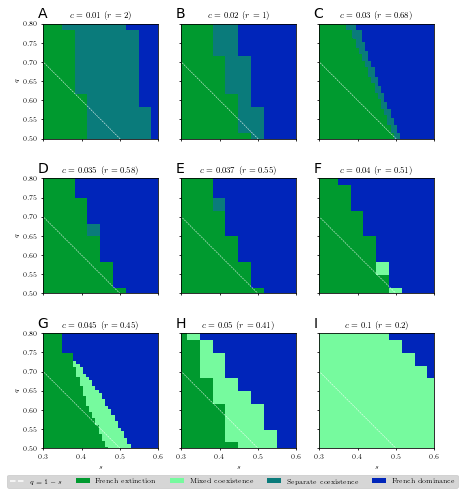

In [218]:
fig = plt.figure(figsize=(17.8/2.54, 1.06*17.8/2.54), constrained_layout=False)
gs = fig.add_gridspec(3, 3, bottom=0.06)
axes = gs.subplots()
c_values = (0.01, 0.02, 0.03, 0.035, 0.037, 0.04, 0.045, 0.05, 0.1)
plot_iter = zip(c_values, axes.flat)
for c_idx, (c, ax) in enumerate(plot_iter):
    list_s = []
    list_q = []
    converg_dict = {kind: [] for kind in conv_kinds}
    params['c'] = c
            
    for match in futils.yield_paramed_matches(file_format, params, simu_res_dir):
        path = match.string
        s = float(match.group('s'))
        list_s.append(s)
        q = float(match.group('q'))
        list_q.append(q)
        with open(os.path.join(simu_res_dir, path)) as f:
            res_lings_dict = json.load(f)
        for ling, ling_dict in res_lings_dict.items():
            roll_avg = np.mean(ling_dict['window_props'])
            ling_dict['roll_avg'] = roll_avg
        fr_extinct = res_lings_dict['ling_fr']['roll_avg'] + res_lings_dict['ling_frnl']['roll_avg'] < 0.05
        en_extinct = res_lings_dict['ling_nl']['roll_avg'] + res_lings_dict['ling_frnl']['roll_avg'] < 0.05
        if fr_extinct:
            case_kind = 'fr_extinct'
        elif en_extinct:
            case_kind = 'nl_extinct'
        else:
            simu_cell_file = path.replace('json', 'csv').replace('res', 'cell_plot_df')
            simu_res_file_path = os.path.join(simu_res_dir, simu_cell_file)
            cell_step_res = pd.read_csv(simu_res_file_path)
            cell_step_res, _ = metrics.calc_by_cell(cell_step_res, plot_lings_dict, cell_size=cell_size)
            if np.mean(np.abs(1-cell_step_res['Hp'])) < 0.1:
                case_kind = 'mixed_coex'
            else:
                case_kind = 'sep_coex'
        converg_dict[case_kind].append((s, q))
    
    list_s = np.unique(list_s)
    list_q = np.unique(list_q)
    ax = sim_viz.phase_space(ax, converg_dict, list_s, list_q, conv_kinds_c)
    r = params['mu'] / (c * (1-params['mu']))
    ax.set_title(f'$c = {c}$ ($r = {r:.2g}$)')
    if c_idx % 3 > 0:
        ax.set_ylabel(None)
        ax.tick_params(labelleft=False)
    if c_idx // 3 < 2:
        ax.set_xlabel(None)
        ax.tick_params(labelbottom=False)
    ax.annotate(annotations[c_idx], (-0.05, 1.05),
                xycoords='axes fraction', **annotate_kwargs)

# Legend axis at bottom
guide_artist = plt.Line2D((0,1), (0,0), c='w', ls='--')
conv_kinds_artists = [patches.Rectangle((0,0), 1, 1, facecolor=c) for c in conv_kinds_c]
conv_kinds_labels = ['French extinction', 'Mixed coexistence', 'Separate coexistence', 'French dominance']
lgd = fig.legend([guide_artist] + conv_kinds_artists,
                 [r'$q = 1 -s$'] + conv_kinds_labels,
                 loc='lower center', ncol=5, facecolor=[0.8]*3)
save_path = os.path.join(fig_dir, cc, 'metapop_phase_space_all_c.pdf')
fig.savefig(save_path, bbox_inches='tight')
fig.show()

1.2490795826710843

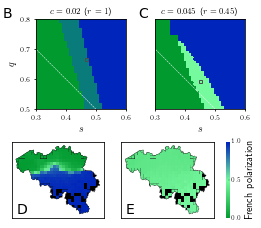

In [63]:
total_width = 8.7/2.54
ratio_h1_h2 = width/height * (1+0.5*2/49)
total_height = total_width/2 * (1 + 1/ratio_h1_h2)
fig = plt.figure(figsize=(total_width, total_height), constrained_layout=True)
gs = fig.add_gridspec(2, 1, height_ratios=[1.2*ratio_h1_h2, 1])
gs_ax = gs[0].subgridspec(1, 2)
gs_axins = gs[1].subgridspec(1, 3, width_ratios=[49,49,2])
fig.set_constrained_layout_pads(w_pad=0/72, wspace=0.1)
axes = gs_ax.subplots()
axinses = gs_axins.subplots()
cax = axinses[2]
list_annot_xpos = [0.01, 0.53]
plot_iter = zip(c_values, (0.467, 0.45), (0.667, 0.592), axes, axinses)
for c_idx, (c, s_case, q_case, ax, axins) in enumerate(plot_iter):
    list_s = []
    list_q = []
    converg_dict = {kind: [] for kind in conv_kinds}
    params['c'] = c
            
    for match in futils.yield_paramed_matches(file_format, params, simu_res_dir):
        path = match.string
        s = float(match.group('s'))
        list_s.append(s)
        q = float(match.group('q'))
        list_q.append(q)
        with open(os.path.join(simu_res_dir, path)) as f:
            res_lings_dict = json.load(f)
        for ling, ling_dict in res_lings_dict.items():
            roll_avg = np.mean(ling_dict['window_props'])
            ling_dict['roll_avg'] = roll_avg
        low_fr_roll_avg = (res_lings_dict['ling_fr']['roll_avg']
                           + res_lings_dict['ling_frnl']['roll_avg']) < 0.05
#         very_low_last_fr = np.min(
#             np.asarray(res_lings_dict['ling_fr']['window_props'])
#             + np.asarray(res_lings_dict['ling_frnl']['window_props'])) < 0.01
#         fr_extinct = low_fr_roll_avg or very_low_last_fr
        low_nl_roll_avg = (res_lings_dict['ling_nl']['roll_avg']
                           + res_lings_dict['ling_frnl']['roll_avg']) < 0.05
#         very_low_last_nl = np.min(
#             np.asarray(res_lings_dict['ling_nl']['window_props'])
#             + np.asarray(res_lings_dict['ling_frnl']['window_props'])) < 0.01
#         nl_extinct = low_nl_roll_avg or very_low_last_nl
        if low_fr_roll_avg:
            case_kind = 'fr_extinct'
        elif low_nl_roll_avg:
            case_kind = 'nl_extinct'
        else:
            simu_cell_file = path.replace('json', 'csv').replace('res', 'cell_plot_df')
            simu_res_file_path = os.path.join(simu_res_dir, simu_cell_file)
            cell_step_res = pd.read_csv(simu_res_file_path)
            cell_step_res, _ = metrics.calc_by_cell(cell_step_res, plot_lings_dict, cell_size=cell_size)
            if np.mean(np.abs(1-cell_step_res['Hp'])) < 0.1:
                case_kind = 'mixed_coex'
            else:
                case_kind = 'sep_coex'
        converg_dict[case_kind].append((s, q))
    
    list_s = np.unique(list_s)
    list_q = np.unique(list_q)
    plot_params = params.copy()
    plot_params.update({'c': c, 's': s_case, 'q': q_case})
    params_str = '_'.join([f'{key}={value}' for key, value in plot_params.items()])
    simu_res_file_path = os.path.join(simu_res_dir, f'cell_plot_df_{params_str}.csv')
    cell_step_res = pd.read_csv(simu_res_file_path)
    cell_step_res, _ = metrics.calc_by_cell(cell_step_res, plot_lings_dict, cell_size=cell_size)
    cell_plot_df = cells_in_area_df[['geometry']].join(cell_step_res.set_index('res_cell_id'))
    cell_plot_df['fr_polar'] = 0.5 * (1 + cell_plot_df['prop_ling_fr'] - cell_plot_df['prop_ling_nl'])
    
    fig, ax, axins = sim_viz.phase_space_eg(
        converg_dict, list_s, list_q, plot_params, c_values, cell_plot_df,
        shape_df, fig, ax, axins, conv_kinds_c, tight_layout=False, cax=cax)
    annot_xpos = list_annot_xpos[c_idx]
    art = ax.annotate(annotations[c_idx+1], (annot_xpos, 0.92),
                      xycoords='figure fraction', **annotate_kwargs)
    # Remove from layout so that other axes are not pushed away by the annotation.
    art.set_in_layout(False)
    art = axins.annotate(annotations[len(c_values)+c_idx+1], (0.05, 0.05),
                         xycoords='axes fraction', **annotate_kwargs)
    art.set_in_layout(False)

save_path = os.path.join(fig_dir, cc, f'metapop_phase_space_eg_c.pdf')
fig.savefig(save_path)
fig.show()

### Lattice stuff

In [47]:
import src.models.lattice as latt

In [135]:
size = 50
N_agents = size**2
# Init with random lattice
latt_state = np.random.rand(N_agents)
latt_state[latt_state > 2/3] = 2
latt_state[latt_state < 1/3] = 1
latt_state[latt_state < 2/3] = 0
# lattice_state = lattice_state.reshape((size, size)).astype(int)
latt_state = latt_state.astype(int)
neighbors = latt.get_neighbors(size)
# neigh_state is only used in the init and won't be updated then, only 
# latt_state and the counts will be.
# neigh_state = lattice_state[neighbors[:,:,:,0], neighbors[:,:,:,1]]
neigh_state = latt_state[neighbors]
count_A = np.sum(neigh_state == 0, axis=1)
count_B = np.sum(neigh_state == 1, axis=1)
list_latt_states = [latt_state.copy()]
count = 0

In [138]:
# latt_params = params.copy()
# latt_params['rate'] = 2
latt_params = {'s': 0.4, 'a': 1, 'rate': 10, 'mu': 0.02, 'c': 0.01, 'q': 0.5}
nr_steps = 1000
pick_draws = (np.random.rand(nr_steps * N_agents) * N_agents).astype(int)
shift_draws = np.random.rand(nr_steps * N_agents)
for t_step in range(nr_steps):
    for k in range(N_agents):
        draw_nr = t_step*N_agents + k
        agent_idx = pick_draws[draw_nr]
        state = latt_state[agent_idx]
        sigma_A = count_A[agent_idx] / 4
        sigma_B = count_B[agent_idx] / 4
        shift_draw = shift_draws[draw_nr]
        new_state = latt.bi_pref_shift(state, sigma_A, sigma_B, shift_draw,
                                       **latt_params)
        if new_state != state:
            count += 1
            count_A[agent_idx] += int(new_state == 0) - int(state == 0)
            count_B[agent_idx] += int(new_state == 1) - int(state == 1)
            latt_state[agent_idx] = new_state
    list_latt_states.append(latt_state.copy())

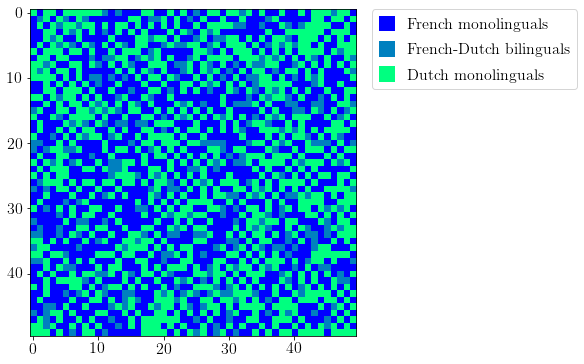

In [139]:
import matplotlib.cm
from matplotlib.patches import Patch, Rectangle
cmap = matplotlib.cm.get_cmap('winter')
latt_state = list_latt_states[-1]
latt_plot = latt_state.copy() #latt_state
# CHange bilinguals to 1 so they're in the middle of colormap
latt_plot[latt_state == 2] = 1
latt_plot[latt_state == 1] = 2
latt_plot = latt_plot.reshape((size, size))
fig, ax = plt.subplots(1, figsize=(10, 6))
im = ax.imshow(latt_plot, cmap=cmap)
lgd_colorbox = [Patch(fc=cmap(0.)),
                Patch(fc=cmap(.5)),
                Patch(fc=cmap(1.))]
lgd_labels = [ling_dict['grp_label'] for ling_dict in plot_lings_dict.values()]
ax.legend(lgd_colorbox, [lgd_labels[0], lgd_labels[2], lgd_labels[1]],
          handlelength=1, handleheight=1.125,
          bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

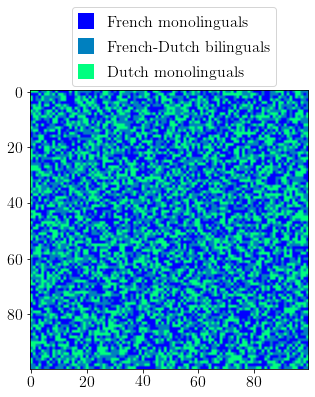

In [1134]:
import matplotlib.cm
from matplotlib.patches import Patch, Rectangle
from matplotlib import animation
cmap = matplotlib.cm.get_cmap('winter')
list_latt_plot = []
for latt_state in list_latt_states:
    latt_plot = latt_state.copy()
    # CHange bilinguals to 1 so they're in the middle of colormap
    latt_plot[latt_state == 2] = 1
    latt_plot[latt_state == 1] = 2
    latt_plot = latt_plot.reshape((size, size))
    list_latt_plot.append(latt_plot)
    
fig, ax = plt.subplots(1, figsize=(10, 6))
# fig = plt.figure(figsize=(10, 6))
# ax = fig.add_axes([0.1, 0.1, 0.6, 0.75])
im = ax.imshow(list_latt_plot[0], cmap=cmap)
lgd_colorbox = [Patch(fc=cmap(0.)),
                Patch(fc=cmap(.5)),
                Patch(fc=cmap(1.))]
lgd_labels = [ling_dict['grp_label'] for ling_dict in plot_lings_dict.values()]
ax.legend(lgd_colorbox, [lgd_labels[0], lgd_labels[2], lgd_labels[1]],
          handlelength=1, handleheight=1.125,
          bbox_to_anchor=(0.15, 1.3), loc=2, borderaxespad=0.)

def animate(i):
    im.set_array(list_latt_plot[i])
    return im,

fig.tight_layout()
anim_args = np.arange(len(list_latt_plot))
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, anim_args, #init_func=init, 
                               interval=1000, blit=True, repeat=False)

## Spatial prestige tests

In [292]:
def logistic(pAi, pBi, pA, pB, k=1):
    value = np.zeros(pAi.shape)
    if pBi > 0:
        value[pAi > 0] = 1 / (1 + (pAi[pAi > 0] / pA * pB / pBi)**(-k))
    else:
        value = np.ones(pAi.shape)
    return value

Logistic prestige tests:

In [79]:
cell_res = user_df.groupby('res_cell_id').size()
cell_workers = user_df.groupby('work_cell_id').size()
lings = list(plot_lings_dict.keys())
mono_A_mask = user_df['ling'] == lings[0]
mono_B_mask = user_df['ling'] == lings[1]
sigma_A, sigma_B, global_sigma_A, global_sigma_B = lang_abm.get_sigmas(
    user_df, mono_A_mask, mono_B_mask, cell_res)
res_prestige_A = lang_abm.get_prestige(
    sigma_A, sigma_B, global_sigma_A, global_sigma_B, k=0.3)
sigma_A, sigma_B, global_sigma_A, global_sigma_B = lang_abm.get_sigmas(
    user_df, mono_A_mask, mono_B_mask, cell_workers)
work_prestige_A = lang_abm.get_prestige(
    sigma_A, sigma_B, global_sigma_A, global_sigma_B)

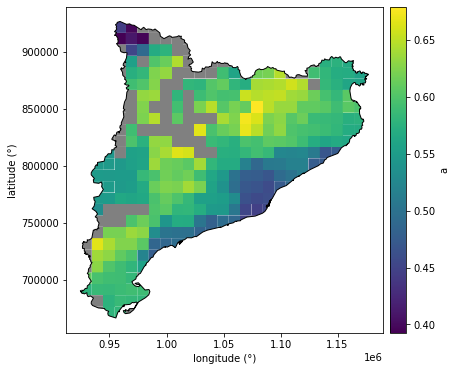

In [80]:
b = res_prestige_A
b.index = b.index.rename('cell_id')
b = b.rename('prestige_A')
ax = grid_viz.plot_grid(cells_in_area_df[['geometry']].join(b), shape_df, metric_col='prestige_A', cbar_label='a')

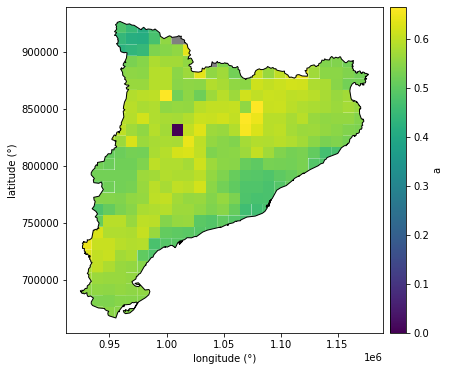

In [47]:
b = work_prestige_A
b.index = b.index.rename('cell_id')
b = b.rename('prestige_A')
ax = grid_viz.plot_grid(cells_in_area_df[['geometry']].join(b), shape_df,
                        metric_col='prestige_A', cbar_label='a')

# Catalonia

In [87]:
cc = 'ES'
region = 'Catalonia'
area_dict = make_config.area_dict(countries_study_data, cc, region=region)
area_name = area_dict['readable']    
cc_fig_dir = os.path.join(fig_dir, cc)
xy_proj = area_dict['xy_proj']
min_poly_area = area_dict.get('min_poly_area')
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_lings_dict['ling_es']['ratio'] = 0.35
plot_lings_dict['ling_ca']['ratio'] = 0.11
plot_lings_dict['ling_caes']['ratio'] = 1 - 0.11 - 0.35
lings = list(plot_lings_dict.keys())

shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj, 
                             min_area=min_poly_area)

cell_size = 10000
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True)

In [8]:
cat_census_path = os.path.join('/data/social/spanish_census_2011',
                               'RESIDENCIA_TRABAJO_PETICIONES.xlsb')
cat_census = pd.read_excel(cat_census_path, engine='pyxlsb')
cat_prov = ['Barcelona', 'Tarragona', 'Lleida', 'Girona']
prov_mask = ((cat_census['LPRO_RESIDENCIA'].isin(cat_prov))
             & (cat_census['LPRO_PAIS_TRABAJO'].isin(cat_prov)))
cat_census = (
    cat_census.rename(columns={'MUN_RESIDENCIA': 'from_muni_id',
                               'MUN_PAIS_TRABAJO': 'to_muni_id',
                               'OCUPADOS': 'count'})
              .loc[prov_mask, ['from_muni_id', 'to_muni_id', 'count']]
              .astype({'to_muni_id': int})
              .set_index(['from_muni_id', 'to_muni_id'])[['count']])
cat_census.head()

count
from_muni_id to_muni_id       
8001         8001         1830
             8019          555
             8076          185
             8114          770
             8147          145

In [9]:
shapefile_name = 'Municipios_IGN.shp'
shapefile_path = os.path.join(external_data_dir, shapefile_name, shapefile_name)
muni_shapes = geopd.read_file(shapefile_path)
muni_shapes = (muni_shapes.loc[muni_shapes['CODNUT2'] == 'ES51']
                          .rename(columns={'CODIGOINE': 'muni_id'})
                          .to_crs(xy_proj)
                          .astype({'muni_id': int})
                          .set_index('muni_id', drop=False))
muni_shapes['area'] = muni_shapes.geometry.area

In [10]:
muni_in_cells = places_to_cells.get_intersect(
    muni_shapes[['muni_id', 'geometry', 'area']], cells_in_area_df)
muni_in_cells = muni_in_cells.set_index(['cell_id', 'muni_id'])[['ratio']]
cell_mobility = mobility.muni_to_cell(cat_census, muni_in_cells)
cell_mobility.head()

count     ratio  to_ratio  \
to_muni_id from_muni_id from_cell_id to_cell_id                              
8001       8001         362          362          1830  0.180238  0.180238   
                                     389          1830  0.180238  0.819762   
                        389          362          1830  0.819762  0.180238   
                                     389          1830  0.819762  0.819762   
           8019         414          389           685  0.001798  0.819762   

                                                 whole_ratio  cell_count  
to_muni_id from_muni_id from_cell_id to_cell_id                           
8001       8001         362          362            0.032486          59  
                                     389            0.147752         270  
                        389          362            0.147752         270  
                                     389            0.672009        1229  
           8019         414          389            0.001474           1

In [567]:
cols = ['from_muni_id', 'to_muni_id']
interaction_sum = (cell_mobility.groupby(cols)['whole_ratio']
                                .sum())
mask = (np.abs(interaction_sum-1) > 1e-1) & (interaction_sum > 0)
nr_not_matching = len(interaction_sum.loc[mask])
if nr_not_matching > 0:
    print(f'Warning: {nr_not_matching} ratios do not sum to 1')
interaction_sum.loc[mask]

from_muni_id  to_muni_id
8029          8219          0.879672
8060          8060          0.806237
8090          8090          0.845144
8118          8118          0.899886
8130          8022          0.786420
                              ...   
43130         43130         0.846587
              43142         0.870648
43136         43136         0.885427
43173         43173         0.801917
43177         43019         0.879886
Name: whole_ratio, Length: 63, dtype: float64

self: 1002378
not self: 1348024
not self, above threshold: 1130355


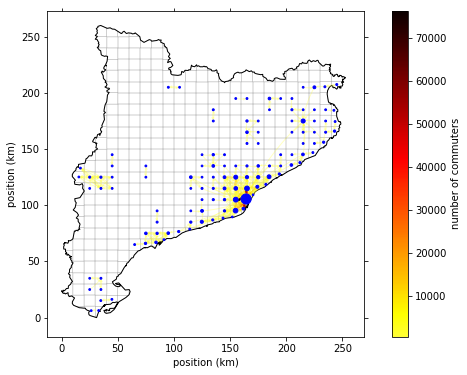

In [10]:
cell_plot_mobility = (
    cell_mobility.groupby(['from_cell_id', 'to_cell_id'])[['cell_count']]
                 .sum()
                 .reset_index()
                 .rename(columns={'cell_count': 'whole_ratio', 
                                  'from_cell_id': 'cell_id'}))
og_cmap = plt.get_cmap('hot').reversed()
edge_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', og_cmap(np.linspace(0.2, 1, 200)))
save_path = os.path.join(
    fig_dir, cc, 'networks',
    f'mobility_network_{area_name}_cell_size={cell_size}m.pdf')
ax = net_viz.plot_cell_interactions(
    cell_plot_mobility, cells_in_area_df, shape_df,
    edge_th=500, save_path=save_path, edge_cmap=edge_cmap,
    cbar_label='number of commuters')

In [11]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
rescale_df = (cell_mobility.groupby('from_cell_id')['cell_count']
                           .sum()
                           .rename('local_count')
                           .to_frame())
cell_plot_df = mobility.rescale_data(
    cell_plot_df, rescale_df,
    plot_lings_dict, min_local_count=5)
cell_mobility = mobility.commut_by_grp(cell_mobility, cell_plot_df, 
                                       plot_lings_dict)
cat_user_dict = mobility.get_user_dict(cell_mobility, plot_lings_dict)
nr_users = len(cat_user_dict['ling'])
cat_user_df = pd.DataFrame(cat_user_dict)
cat_user_df['ling'] = cat_user_df['ling'].astype('category')
cat_user_df.head()

We lost 11737 commuters out of 2350402 because of holes in cell_plot_df


,ling,res_cell_id,work_cell_id
0,ling_ca,389,389
1,ling_ca,389,389
2,ling_ca,389,389
3,ling_ca,389,389
4,ling_ca,389,389


uniform prestige + low volatility = 0.5 -> coexistence but complete mixing of everybody

spatial prestige + low volatility = 0.5 -> coexistence and less mixing than before but still no definite regions (works for rate=1 and rate=0.1)

## Models

### AS

In [186]:
user_df = pd.DataFrame(cat_user_dict)
user_df = user_df.loc[user_df['ling'] != 'ling_caes']
user_df['ling'] = user_df['ling'].astype('category')
model_dict = models_dict['AS']
hist_cell_df = None
prestige_A = None #{'res': 0.5, 'work': 0.5}
params = {'a': 0.5, 'rate': 1}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model=model_dict['short_name'], params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)

In [1271]:
t_steps = 50
user_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
    user_df, cells_in_area_df, model_dict['fun'], lings, t_steps,
    prestige_A=prestige_A, simu_step_file_format=simu_step_file_format,
    hist_cell_df=hist_cell_df, **params)

2020-06-08 11:21:37,168 - src.models.lang_abm - INFO - ling
ling_ca    273782
ling_es    800111
dtype: int64
2020-06-08 11:21:37,861 - src.models.lang_abm - INFO - * step 0 *
2020-06-08 11:21:38,676 - src.models.lang_abm - INFO - ling
ling_ca    199779
ling_es    874114
dtype: int64
2020-06-08 11:21:39,508 - src.models.lang_abm - INFO - ling
ling_ca    154111
ling_es    919782
dtype: int64
2020-06-08 11:21:39,511 - src.models.lang_abm - INFO - * step 1 *
2020-06-08 11:21:40,338 - src.models.lang_abm - INFO - ling
ling_ca    133446
ling_es    940447
dtype: int64
2020-06-08 11:21:41,199 - src.models.lang_abm - INFO - ling
ling_ca    120376
ling_es    953517
dtype: int64
2020-06-08 11:21:41,201 - src.models.lang_abm - INFO - * step 2 *
2020-06-08 11:21:42,033 - src.models.lang_abm - INFO - ling
ling_ca    114696
ling_es    959197
dtype: int64
2020-06-08 11:21:42,864 - src.models.lang_abm - INFO - ling
ling_ca    109527
ling_es    964366
dtype: int64
2020-06-08 11:21:42,866 - src.models.la

s=0.5, a=1, rate=1 => uniformisation

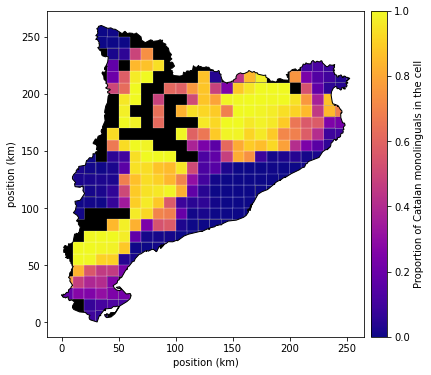

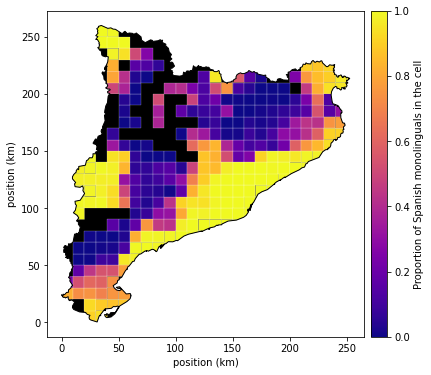

In [1273]:
new_cell_df = hist_cell_df[50]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=0)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_caes'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

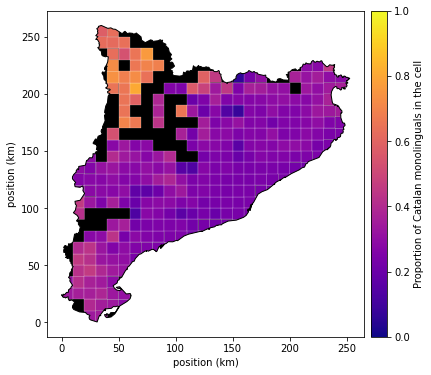

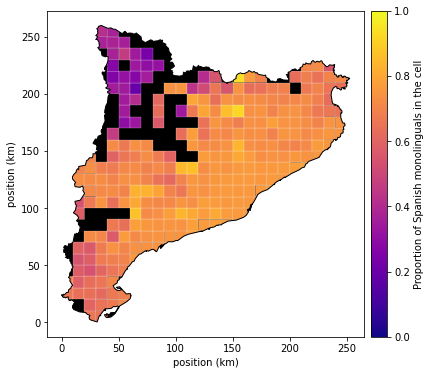

In [1122]:
new_cell_df = hist_cell_df[500]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=0)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_caes'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

s=0.5, a=0.5, rate=1 => uniformisation

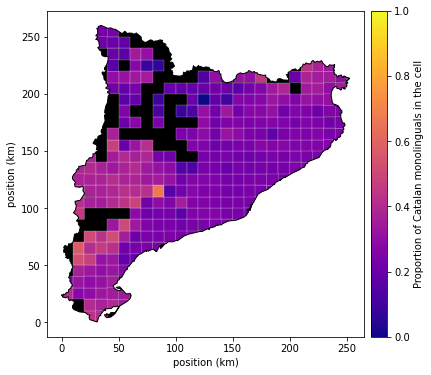

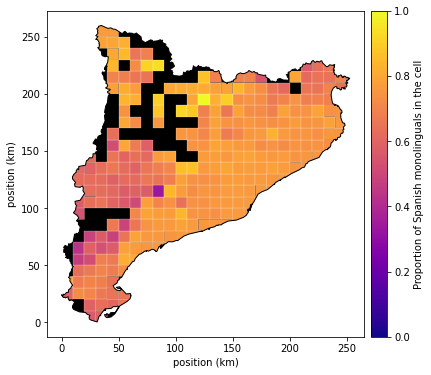

In [1103]:
new_cell_df = cat_as_hist_cell_df[300]
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_caes'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

s(x), a=0.5, rate=1 => separate regions

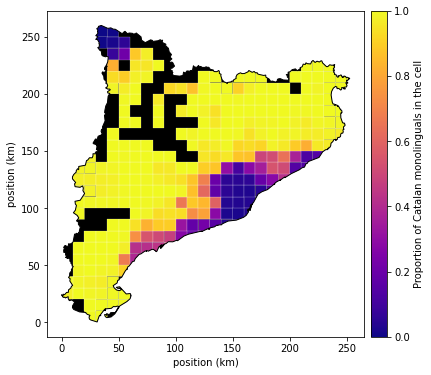

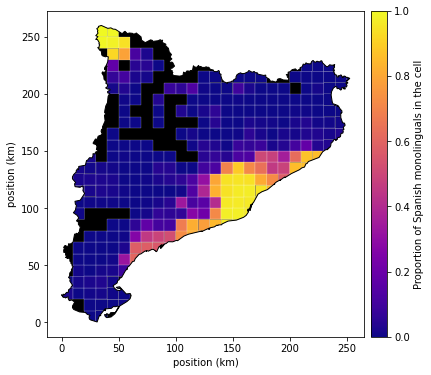

In [1066]:
new_cell_df = cat_as_hist_cell_df[100]
mono_ling_dict = {ling: ling_dict for ling, ling_dict in plot_lings_dict.items() if ling!='ling_caes'}
new_cell_df, mono_ling_dict = metrics.calc_by_cell(
    new_cell_df, mono_ling_dict, cell_size=cell_size)
prop_dict = {'name': 'prop', 'readable': 'Proportion', 'log_scale': False, 
             'vmin': 0, 'vmax': 1, 'total_count_col': 'local_count'}
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, mono_ling_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

### Bilingual

In [88]:
model_dict = models_dict['bi_pref']
prestige_A = {'res': 0.45, 'work': 0.45}
params = {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.05, 'q': 0.6}
# params = {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.1, 'q': 0.6}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model=model_dict['short_name'], params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)
    
# cat_user_df = pd.DataFrame(cat_user_dict)
# cat_user_df['ling'] = cat_user_df['ling'].astype('category')
# hist_cell_df = None

In [18]:
cat_user_df = pd.read_csv('cat_user_df.csv').set_index('Unnamed: 0')

In [ ]:
t_steps = 200
for k in range(20):
    params['c'] -= 0.002
    cat_user_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
        cat_user_df, cells_in_area_df, model_dict['fun'], lings, t_steps,
        prestige_A=prestige_A, simu_step_file_format=simu_step_file_format,
        hist_cell_df=hist_cell_df, **params)

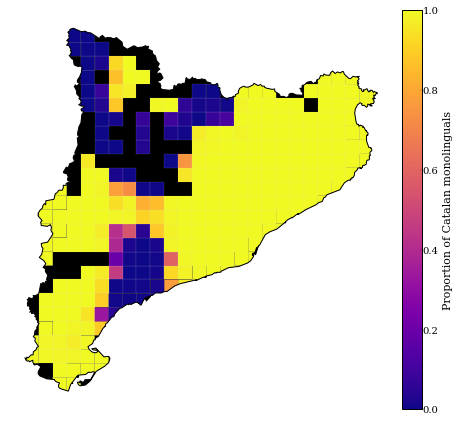

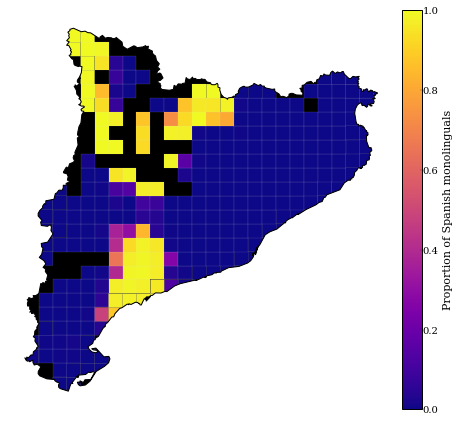

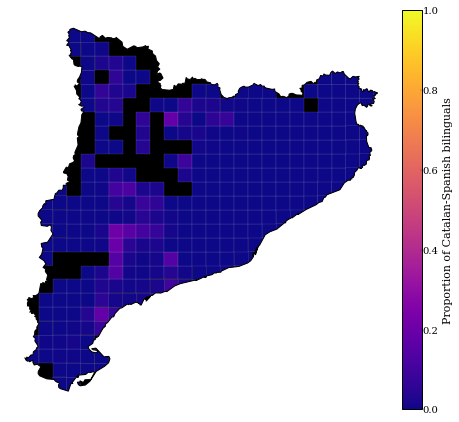

In [59]:
new_cell_df = hist_cell_df[-1]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=80)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
new_cell_df, plot_lings_dict = metrics.calc_by_cell(
    new_cell_df, plot_lings_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
fig_save_path_format = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format = None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, plot_lings_dict,
    save_path_format=fig_save_path_format, xy_proj=xy_proj,
    null_color='k')

In [57]:
x_data = np.arange(1, len(hist_cell_df), 1)
nr_users = len(cat_user_dict['ling'])
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
for t_step in x_data:
    cell_counts_df = pd.read_csv(simu_step_file_format.format(t_step=t_step),
                                 usecols=count_cols)
#     cell_counts_df = hist_cell_df[t_step]
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

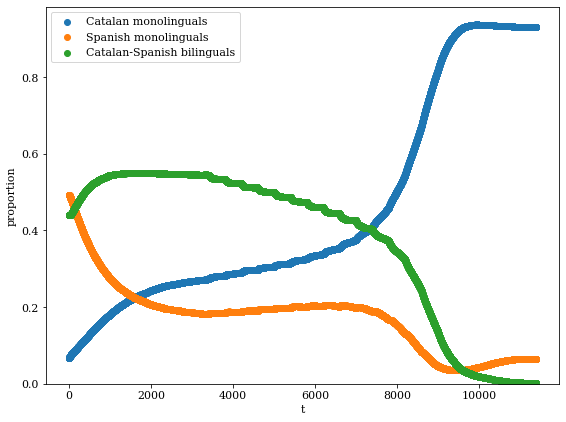

In [58]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

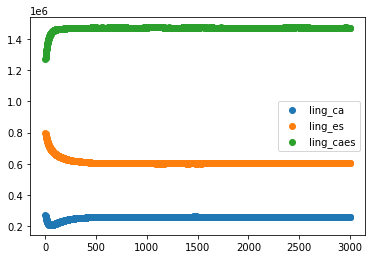

In [325]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

### Bilingual prestige?

In [1366]:
user_df = pd.DataFrame(cat_user_dict)
user_df['ling'] = user_df['ling'].astype('category')
hist_cell_df = None
prestige_A = None #{'res': 0.2, 'work': 0.2}
prestige_B = None #{'res': 0.2, 'work': 0.2}
params = {'a': 1, 'rate': 1}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model='sAB_cheat', params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)

In [1367]:
t_steps = 1
user_df, hist_cell_df, prestige_A, prestige_B = lang_abm.bi_prestige_simu_wrapper(
    user_df, cells_in_area_df, lings, t_steps,
    prestige_A=prestige_A, prestige_B=prestige_B, simu_step_file_format=simu_step_file_format,
    hist_cell_df=hist_cell_df, **params)

2020-06-10 10:19:33,685 - src.models.lang_abm - INFO - ling
ling_ca       273782
ling_caes    1264772
ling_es       800111
dtype: int64
2020-06-10 10:19:35,131 - src.models.lang_abm - INFO - * step 0 *
2020-06-10 10:19:36,950 - src.models.lang_abm - INFO - ling
ling_ca       339123
ling_caes     863111
ling_es      1136431
dtype: int64
2020-06-10 10:19:38,859 - src.models.lang_abm - INFO - ling
ling_ca       326538
ling_caes     702114
ling_es      1310013
dtype: int64


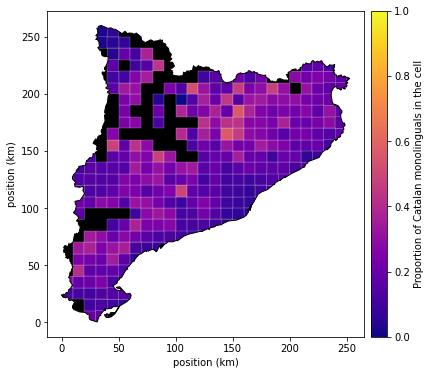

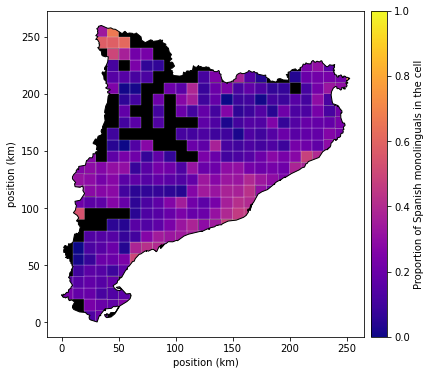

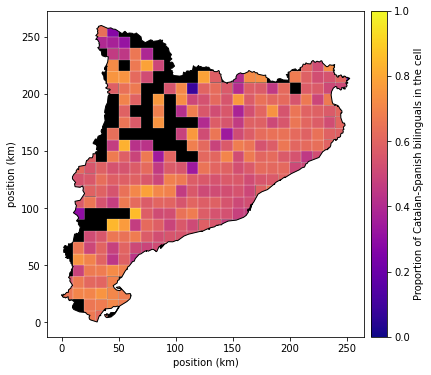

In [1368]:
new_cell_df = hist_cell_df[0]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=80)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
new_cell_df, plot_lings_dict = metrics.calc_by_cell(
    new_cell_df, plot_lings_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    null_color='k')

# Quebec

## Init 

In [531]:
cc = 'CA'
region = 'Quebec'
area_dict = make_config.area_dict(countries_study_data, cc, region=region)
area_name = area_dict['readable']    
cc_fig_dir = os.path.join(fig_dir, cc)
net_fig_dir = os.path.join(cc_fig_dir, 'networks')
if not os.path.exists(net_fig_dir):
    os.makedirs(net_fig_dir)
xy_proj = area_dict['xy_proj']
cc_timezone = area_dict['timezone']
plot_langs_list = area_dict['local_langs']
min_poly_area = area_dict.get('min_poly_area')
plot_langs_dict = make_config.langs_dict(area_dict, user_level_label)
plot_lings_dict = make_config.linguals_dict(area_dict)
plot_multi_mono_dict = make_config.multi_mono_dict(plot_lings_dict)
# plot_lings_dict['ling_fr']['ratio'] = 0.518 / (0.518+0.047+0.426)
# plot_lings_dict['ling_en']['ratio'] = 0.047 / (0.518+0.047+0.426)
# plot_lings_dict['ling_enfr']['ratio'] = 0.426 / (0.518+0.047+0.426)
# Used knowledge of languages data
sum_ling = 3586410 + 372450 + 4032635
plot_lings_dict['ling_fr']['ratio'] = 4032635 / sum_ling
plot_lings_dict['ling_en']['ratio'] = 372450 / sum_ling
plot_lings_dict['ling_enfr']['ratio'] = 3586410 / sum_ling
lings = list(plot_lings_dict.keys())

shapefile_dict = make_config.shapefile_dict(area_dict, cc, region=region)
    
shapefile_path = os.path.join(
    external_data_dir, shapefile_dict['name'], shapefile_dict['name'])
shape_df = geopd.read_file(shapefile_path)
shape_df = geo.extract_shape(shape_df, shapefile_dict, xy_proj=xy_proj, 
                             min_area=min_poly_area)

cell_size = 20000
cells_df, cells_in_area_df, Nx, Ny = geo.create_grid(
    shape_df, cell_size, xy_proj=xy_proj, intersect=True)

In [456]:
shapefile_name = 'lcsd000b16a_e.shp' # 'lcd_000b16a_e.shp'
shapefile_path = os.path.join(external_data_dir, shapefile_name, shapefile_name)
muni_shapes = geopd.read_file(shapefile_path)
muni_shapes = (muni_shapes.loc[muni_shapes['PRUID'] == '24']
                          .rename(columns={'CSDUID': 'muni_id'})
#                           .rename(columns={'CDUID': 'muni_id'})
                          .to_crs(xy_proj)
                          .astype({'muni_id': int})
                          .set_index('muni_id', drop=False))
muni_shapes['area'] = muni_shapes.geometry.area
muni_shapes.crs = xy_proj
muni_shapes.head()

,muni_id,CSDNAME,CSDTYPE,PRUID,PRNAME,CDUID,CDNAME,CDTYPE,CCSUID,CCSNAME,ERUID,ERNAME,SACCODE,SACTYPE,CMAUID,CMAPUID,CMANAME,CMATYPE,geometry,area
muni_id,,,,,,,,,,,,,,,,,,,,
2404030,2404030,La Martre,MÉ,24,Quebec / Québec,2404,La Haute-Gaspésie,MRC,2404047,Cap-Chat,2410,Gaspésie--Îles-de-la-Madeleine,997,5,None,None,None,None,"POLYGON ((173364.308 581279.439, 174022.384 57...",1.762631e+08
2404037,2404037,Sainte-Anne-des-Monts,V,24,Quebec / Québec,2404,La Haute-Gaspésie,MRC,2404047,Cap-Chat,2410,Gaspésie--Îles-de-la-Madeleine,998,6,None,None,None,None,"POLYGON ((161685.821 574869.261, 164427.058 57...",2.651508e+08
2407080,2407080,Val-Brillant,MÉ,24,Quebec / Québec,2407,La Matapédia,MRC,2407080,Val-Brillant,2415,Bas-Saint-Laurent,997,5,None,None,None,None,"POLYGON ((72228.069 505121.025, 72956.031 5046...",9.198496e+07
2404025,2404025,Marsoui,VL,24,Quebec / Québec,2404,La Haute-Gaspésie,MRC,2404047,Cap-Chat,2410,Gaspésie--Îles-de-la-Madeleine,998,6,None,None,None,None,"POLYGON ((181975.328 583051.748, 182595.158 57...",1.831028e+08
2411010,2411010,Saint-Jean-de-Dieu,MÉ,24,Quebec / Québec,2411,Les Basques,MRC,2411010,Saint-Jean-de-Dieu,2415,Bas-Saint-Laurent,997,5,None,None,None,None,"POLYGON ((-25655.531 444617.779, -23545.894 44...",1.525468e+08


In [451]:
ling_census_df = pd.read_csv(os.path.join(external_data_dir, 'quebec_2016_csd_ling.csv'), index_col='id')
ling_census_df.head()

,count_ling_enfr,count_ling_en,count_ling_fr,local_count,prop_ling_fr,prop_ling_en,prop_ling_enfr
id,,,,,,,
2401023,2670,120,9095,11885,0.765250,0.010097,0.224653
2401042,140,315,15,470,0.031915,0.670213,0.297872
2402005,840,385,1855,3080,0.602273,0.125000,0.272727
2402010,90,5,910,1005,0.905473,0.004975,0.089552
2402015,435,5,2970,3410,0.870968,0.001466,0.127566


In [464]:
muni_in_cells = places_to_cells.get_intersect(
    muni_shapes[['muni_id', 'geometry', 'area']], cells_in_area_df)
muni_in_cells = muni_in_cells.set_index(['cell_id', 'muni_id'])[['ratio']]
muni_in_cells.head()

,,ratio
cell_id,muni_id,
12,2485005,0.008760
13,2485005,0.075838
37,2485005,0.057040
38,2485005,0.263104
39,2485005,0.278883


In [ ]:
muni_cells_ling = muni_in_cells.join(ling_census_df.rename_axis('muni_id'))

## Validation with ling census

In [ ]:
for ling in plot_lings_dict:
    muni_cells_ling['count_'+ling] *=  muni_cells_ling['ratio']
census_cell_plot_df = muni_cells_ling.groupby('cell_id')[['count_'+ling for ling in plot_lings_dict]].sum()

In [467]:
census_cell_plot_df['local_count'] = sum([census_cell_plot_df['count_'+ling] for ling in plot_lings_dict])
for ling in plot_lings_dict:
    census_cell_plot_df['prop_'+ling] = census_cell_plot_df['count_'+ling] / census_cell_plot_df['local_count']
census_cell_plot_df.head()

,count_ling_en,count_ling_fr,count_ling_enfr,local_count,prop_ling_en,prop_ling_fr,prop_ling_enfr
cell_id,,,,,,,
12,3.723127,3.460318,13.928876,21.112322,0.176349,0.163900,0.659751
13,33.040867,34.815193,127.870786,195.726846,0.168811,0.177876,0.653312
14,4.256891,292.797746,112.106765,409.161402,0.010404,0.715605,0.273992
15,9.449518,2750.264217,1165.981227,3925.694962,0.002407,0.700580,0.297013
16,19.716232,1607.316823,663.857183,2290.890237,0.008606,0.701612,0.289781


In [536]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
cell_plot_df.index = cell_plot_df['cell_id']
rescale_df = census_cell_plot_df['local_count'].to_frame()
cell_plot_df = mobility.rescale_data(cell_plot_df, rescale_df, plot_lings_dict)
for ling in plot_lings_dict:
    count_col = 'count_' + ling
    cell_plot_df['prop_' + ling] = cell_plot_df[count_col] / cell_plot_df['local_count']
    cell_plot_df['conc_' + ling] = cell_plot_df[count_col] / cell_plot_df[count_col].sum()
cell_plot_df.head()

,count_ling_en,count_ling_fr,count_ling_enfr,geometry,local_count,total_count,cell_id,prop_ling_en,conc_ling_en,prop_ling_fr,conc_ling_fr,prop_ling_enfr,conc_ling_enfr
cell_id,,,,,,,,,,,,,
39,1071.620808,0.000000,395.486637,"POLYGON ((-810566.145 377179.444, -790566.145 ...",1467.107445,1467.107445,39,0.730431,0.003167,0.000000,0.000000,0.269569,0.000121
74,67.825562,1799.169482,728.281057,"POLYGON ((-790566.145 537179.444, -770566.145 ...",2595.276100,2595.276100,74,0.026134,0.000200,0.693248,0.000491,0.280618,0.000224
77,177.768919,4017.534581,3706.424402,"POLYGON ((-790566.145 597179.444, -770566.145 ...",7901.727902,7901.727902,77,0.022497,0.000525,0.508437,0.001097,0.469065,0.001138
183,187.377379,604.668320,4350.923227,"POLYGON ((-710566.145 557179.444, -690566.145 ...",5142.968925,5142.968925,183,0.036434,0.000554,0.117572,0.000165,0.845994,0.001335
208,185.704641,1669.291802,1376.407414,"POLYGON ((-690566.145 517179.444, -670566.145 ...",3231.403858,3231.403858,208,0.057469,0.000549,0.516584,0.000456,0.425947,0.000422


In [1332]:
## changed outer to left
comp_df = cell_plot_df.join(census_cell_plot_df, rsuffix='census', how='left')
comp_df['local_count'] = comp_df['local_count'].fillna(0)
# comp_df = cells_in_area_df.join(comp_df)
comp_df.head()

,count_ling_en,count_ling_fr,count_ling_enfr,geometry,local_count,cell_id,prop_ling_en,conc_ling_en,prop_ling_fr,conc_ling_fr,prop_ling_enfr,conc_ling_enfr,count_ling_encensus,count_ling_frcensus,count_ling_enfrcensus,local_countcensus,prop_ling_encensus,prop_ling_frcensus,prop_ling_enfrcensus
cell_id,,,,,,,,,,,,,,,,,,,
39,1071.620808,0.000000,395.486637,"POLYGON ((-810566.145 377179.444, -790566.145 ...",1467.107445,39,0.730431,0.003167,0.000000,0.000000,0.269569,0.000121,473.525172,175.158689,818.423584,1467.107445,0.322761,0.119390,0.557848
74,67.825562,1799.169482,728.281057,"POLYGON ((-790566.145 537179.444, -770566.145 ...",2595.276100,74,0.026134,0.000200,0.693248,0.000491,0.280618,0.000224,6.786649,1721.649342,866.840110,2595.276100,0.002615,0.663378,0.334007
77,177.768919,4017.534581,3706.424402,"POLYGON ((-790566.145 597179.444, -770566.145 ...",7901.727902,77,0.022497,0.000525,0.508437,0.001097,0.469065,0.001138,0.000000,6615.398605,1286.329297,7901.727902,0.000000,0.837209,0.162791
183,187.377379,604.668320,4350.923227,"POLYGON ((-710566.145 557179.444, -690566.145 ...",5142.968925,183,0.036434,0.000554,0.117572,0.000165,0.845994,0.001335,8.477373,3974.231470,1160.260082,5142.968925,0.001648,0.772750,0.225601
208,185.704641,1669.291802,1376.407414,"POLYGON ((-690566.145 517179.444, -670566.145 ...",3231.403858,208,0.057469,0.000549,0.516584,0.000456,0.425947,0.000422,28.151620,2136.004199,1067.248038,3231.403858,0.008712,0.661014,0.330274


Weighted average of error

In [1329]:
for ling in plot_lings_dict:
    print(ling)
    print((comp_df['local_count'] * (comp_df['prop_'+ling] - comp_df['prop_'+ling+'census'])).sum() / comp_df['local_count'].sum())
    print((comp_df['local_count'] * (comp_df['prop_'+ling] - comp_df['prop_'+ling+'census']).abs()).sum() / comp_df['local_count'].sum())

ling_en
-0.00014626797038280945
0.02798967637351714
ling_fr
0.021595422118706985
0.09843956112827051
ling_enfr
-0.02144915414832414
0.08441092890598423


Distribution? pb with relative error of scale...

ling_en


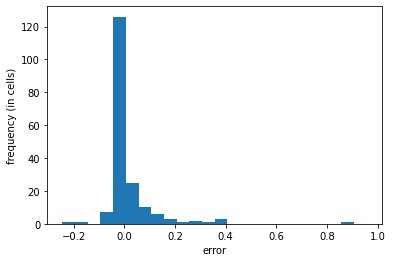

ling_fr


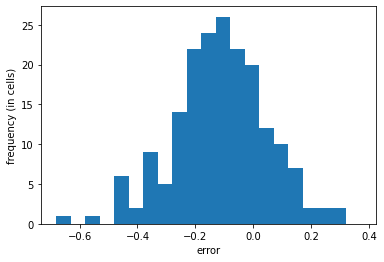

ling_enfr


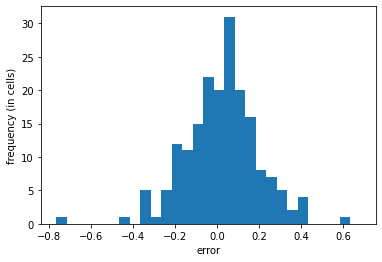

In [94]:
show = True
# nr_bins = 20
for ling in plot_lings_dict:
    print(ling)
    comp_df['error'] = comp_df['prop_' + ling] - comp_df['prop_' + ling + 'census']

    max_dist = comp_df['error'].max()
    min_dist = comp_df['error'].min()
    # +1 to include the max in the last bin
#     bin_size = (max_dist-min_dist) / (nr_bins-1)
    bin_size = 0.05
    bins = np.arange(min_dist, max_dist+bin_size, bin_size)
    comp_df['bin'] = (comp_df['error']-min_dist) // bin_size
    # bin_heights = comp_df.groupby('bin').size()
    bin_heights = comp_df.groupby('bin').size()
    bin_heights = bin_heights.reindex(range(len(bins)), fill_value=0)
    plt.xlabel('error')
    plt.ylabel('frequency (in cells)')
    plt.bar(bins, bin_heights, width=bin_size)
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

ling_en


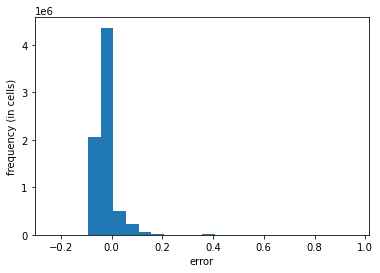

ling_fr


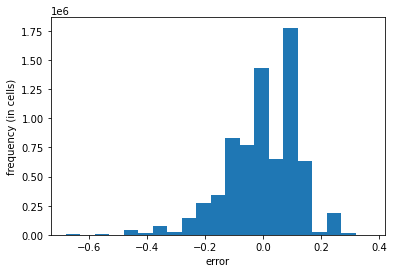

ling_enfr


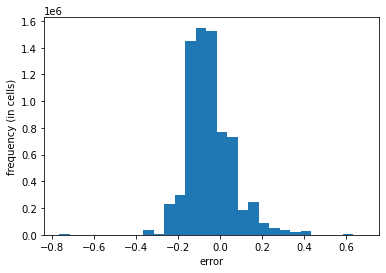

In [93]:
show = True
# nr_bins = 20
for ling in plot_lings_dict:
    print(ling)
    comp_df['error'] = comp_df['prop_' + ling] - comp_df['prop_' + ling + 'census']

    max_dist = comp_df['error'].max()
    min_dist = comp_df['error'].min()
    # +1 to include the max in the last bin
#     bin_size = (max_dist-min_dist) / (nr_bins-1)
    bin_size = 0.05
    bins = np.arange(min_dist, max_dist+bin_size, bin_size)
    comp_df['bin'] = (comp_df['error']-min_dist) // bin_size
    # bin_heights = comp_df.groupby('bin').size()
    bin_heights = comp_df.groupby('bin')['total'].sum()
    bin_heights = bin_heights.reindex(range(len(bins)), fill_value=0)
    plt.xlabel('error')
    plt.ylabel('frequency (in cells)')
    plt.bar(bins, bin_heights, width=bin_size)
    plt.tight_layout()
    # if save_path:
    #     plt.savefig(save_path)
    if show:
        plt.show()
    plt.close()

why not chi2 and KS between the two distribs?

In [1333]:
import src.data.metrics as metrics
for ling in plot_lings_dict:
    comp_df['count_'+ling] = comp_df['count_'+ling].fillna(0)
    comp_df['count_'+ling+'census'] = comp_df['count_'+ling+'census'].fillna(0)
    n_samples = comp_df['count_'+ling].sum()
    obs_col = 'conc_' + ling
    cens_col = 'conc_' + ling + 'census'
    comp_df[obs_col] = comp_df['count_'+ling] / n_samples
    comp_df[cens_col] = (comp_df['count_'+ling+'census'] / 
                                      comp_df['count_'+ling+'census'].sum())
    
    ks_score, p_value = metrics.ks_test_2d(
        comp_df, obs_col, cens_col, Nx, Ny, n_samples)
    print(ling, ks_score, p_value)
    freq_mask = (comp_df['count_'+ling] > 5) & (comp_df['count_'+ling+'census'] > 5)
    chi2_score, normed_score, p_value = metrics.grid_chisquare(
        comp_df.loc[freq_mask], obs_col, cens_col, n_samples)
    print(normed_score, p_value)

ling_en 0.22841301554337434 0.0
1.7310629291457489 0.0
ling_fr 0.09044777597465548 0.0
0.07190136733839617 0.0
ling_enfr 0.07179088568729963 0.0
0.082126630201923 0.0


KS is not well adapted here where some cells concentrate a large part of the population, hence a jump from one cell can be a very large discontinuity. Thus maybe it's very high because of graining, EMD then?

In [1335]:
d_matrix = None
# comp_df['total_conc'] = 1 / comp_df.shape[0]
comp_df['total_conc'] = comp_df['local_count'] / comp_df['local_count'].sum()
for ling, ling_dict in plot_lings_dict.items():
    comp_df['count_'+ling] = comp_df['count_'+ling].fillna(0)
    comp_df['count_'+ling+'census'] = comp_df['count_'+ling+'census'].fillna(0)
    N_grp = comp_df['count_'+ling].sum()
    obs_col = 'conc_' + ling
    cens_col = 'conc_' + ling + 'census'
    comp_df[obs_col] = comp_df['count_'+ling] / N_grp
    comp_df[cens_col] = (comp_df['count_'+ling+'census'] / 
                                      comp_df['count_'+ling+'census'].sum())
    print(ling)
    try:
        emd_value, norm, d_matrix = metrics.earthmover_distance(
            comp_df, 'conc_'+ling, 'conc_'+ling+'census', d_matrix=d_matrix)
        print(emd_value, emd_value / norm)
    except Exception:
        print(Exception)

ling_en
37984.329499827014 0.27226241524347455
ling_fr
18226.211640306865 0.13064104243175534
ling_enfr
15923.717520495029 0.11413732580970141


## Mobility data

In [538]:
ca_census_path = os.path.join(external_data_dir, '98-400-X2016391_ENG_CSV',
                              '98-400-X2016391_English_CSV_data.csv')
ca_census = pd.read_csv(
    ca_census_path, header=0,
    usecols=['GEO_CODE (POR)', 'GEO_CODE (POW)', 
             'Dim: Sex (3): Member ID: [1]: Total - Sex'])
ca_census = (
    ca_census.rename(columns={'GEO_CODE (POR)': 'from_muni_id',
                               'GEO_CODE (POW)': 'to_muni_id',
                               'Dim: Sex (3): Member ID: [1]: Total - Sex': 'count'})
              .astype({'to_muni_id': int}))
qc_muni_ids = muni_shapes['muni_id'].unique()
qc_mask = ((ca_census['from_muni_id'].isin(qc_muni_ids))
           & (ca_census['to_muni_id'].isin(qc_muni_ids)))
qc_census = (ca_census.loc[qc_mask]
                      .set_index(['from_muni_id', 'to_muni_id'])[['count']])
qc_census.head()

count
from_muni_id to_muni_id       
2401         2401         4565
             2403           25
             2423           30
2402         2401           30
             2402         4765

In [339]:
muni_in_cells = places_to_cells.get_intersect(
    muni_shapes[['muni_id', 'geometry', 'area']], cells_in_area_df)
muni_in_cells = muni_in_cells.set_index(['cell_id', 'muni_id'])[['ratio']]
cell_mobility = mobility.muni_to_cell(qc_census, muni_in_cells)
cell_mobility.head()

count     ratio  to_ratio  \
to_muni_id from_cell_id from_muni_id to_cell_id                              
2402       1424         2402         1450         4765  0.013937  0.063666   
                                     1451         4765  0.013937  0.055820   
                                     1475         4765  0.013937  0.050305   
                                     1476         4765  0.013937  0.089818   
                                     1477         4765  0.013937  0.129038   

                                                 whole_ratio  cell_count  
to_muni_id from_cell_id from_muni_id to_cell_id                           
2402       1424         2402         1450           0.000887           4  
                                     1451           0.000778           3  
                                     1475           0.000701           3  
                                     1476           0.001252           5  
                                     1477           0.001798           8

In [340]:
cols = ['from_muni_id', 'to_muni_id']
interaction_sum = (cell_mobility.groupby(cols)['whole_ratio']
                                .sum())
mask = (np.abs(interaction_sum-1) > 1e-1) & (interaction_sum > 0)
nr_not_matching = len(interaction_sum.loc[mask])
if nr_not_matching > 0:
    print(f'Warning: {nr_not_matching} ratios do not sum to 1')
interaction_sum.loc[mask]

from_muni_id  to_muni_id
2402          2403          0.717886
              2405          0.668274
              2466          0.194149
2403          2423          0.409232
2405          2402          0.786976
                              ...   
2494          2423          0.137942
              2493          0.217976
              2494          0.151309
2495          2495          0.578587
2496          2496          0.005518
Name: whole_ratio, Length: 510, dtype: float64

self: 687137
not self: 2360499
not self, above threshold: 1565585


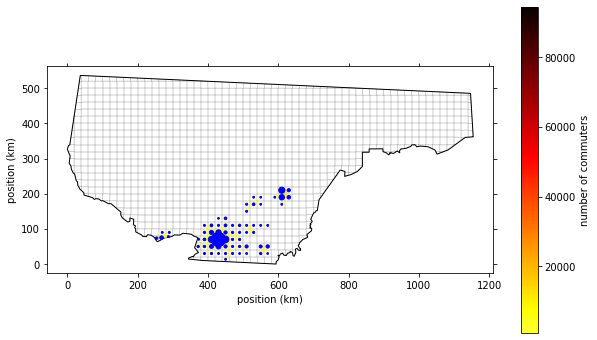

In [416]:
cell_plot_mobility = (
    cell_mobility.groupby(['from_cell_id', 'to_cell_id'])[['cell_count']]
                 .sum()
                 .reset_index()
                 .rename(columns={'cell_count': 'whole_ratio', 
                                  'from_cell_id': 'cell_id'}))
og_cmap = plt.get_cmap('hot').reversed()
edge_cmap = colors.LinearSegmentedColormap.from_list(
    'my_cmap', og_cmap(np.linspace(0.2, 1, 200)))
save_path = os.path.join(
    fig_dir, cc, 'networks',
    f'mobility_network_{area_name}_cell_size={cell_size}m.pdf')
ax = net_viz.plot_cell_interactions(
    cell_plot_mobility, cells_in_area_df, shape_df,
    edge_th=1000, save_path=save_path, edge_cmap=edge_cmap,
    cbar_label='number of commuters')

In [341]:
cell_data_path = cell_data_path_format.format(
    'users_cell_data', cc, area_name, cell_size, 'geojson')
cell_plot_df = geopd.read_file(cell_data_path)
rescale_df = (cell_mobility.groupby('from_cell_id')['cell_count']
                           .sum()
                           .rename('local_count')
                           .to_frame())
cell_plot_df = mobility.rescale_data(
    cell_plot_df, rescale_df, plot_lings_dict, min_local_count=5)
cell_mobility = mobility.commut_by_grp(cell_mobility, cell_plot_df, 
                                       plot_lings_dict)
qc_user_dict = mobility.get_user_dict(cell_mobility, plot_lings_dict)
nr_users = len(qc_user_dict['ling'])
qc_user_df = pd.DataFrame(qc_user_dict)
qc_user_df['ling'] = qc_user_df['ling'].astype('category')
print(qc_user_df.shape)
qc_user_df.head()

We lost 322687 commuters out of 3047636 because of holes in cell_plot_df
(2724949, 3)


,ling,res_cell_id,work_cell_id
0,ling_enfr,39,14
1,ling_en,39,15
2,ling_en,39,16
3,ling_en,39,17
4,ling_enfr,39,38


## Models

In [385]:
qc_user_df = pd.DataFrame(qc_user_dict)
qc_user_df['ling'] = qc_user_df['ling'].astype('category')
model_dict = models_dict['bi_pref']
hist_cell_df = None
prestige_A = {'res': 0.55, 'work': 0.55}
params = {'a': 1, 'rate': 1, 'mu': 0.02, 'c': 0.05, 'q': 0.4}
if prestige_A is None:
    s = 'sx'
else:
    s = prestige_A['res']
params_str = f's={s}_' + '_'.join([f'{key}={value}' for key, value in params.items()])
simu_step_file_format = simu_res_file_format.format(
    cc=cc, cell_size=cell_size, model=model_dict['short_name'], params=params_str, t_step='{t_step}')
simu_res_dir = os.path.split(simu_step_file_format)[0]
if not os.path.exists(simu_res_dir):
    os.makedirs(simu_res_dir)

In [ ]:
t_steps = 500
qc_user_df, hist_cell_df, prestige_A = lang_abm.simu_wrapper(
    qc_user_df, cells_in_area_df, model_dict['fun'], lings, t_steps,
    prestige_A=prestige_A, simu_step_file_format=simu_step_file_format,
    hist_cell_df=hist_cell_df, **params)

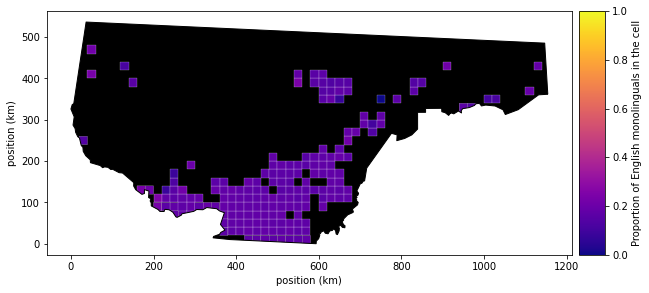

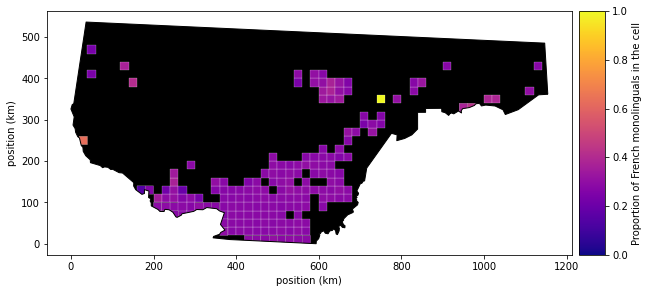

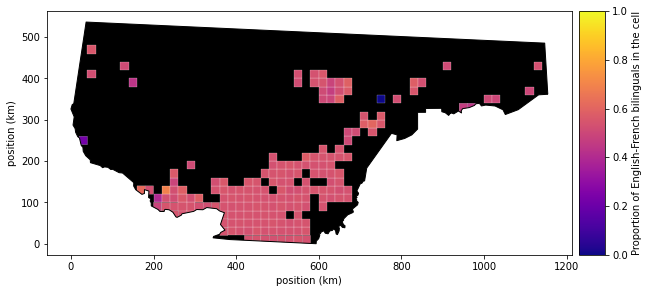

In [409]:
new_cell_df = hist_cell_df[-1]
# new_cell_df = geopd.GeoDataFrame(pd.read_csv(simu_step_file_format.format(t_step=40)).join(
#     cells_in_area_df[['geometry']], on='res_cell_id'), crs=cells_in_area_df.crs)
new_cell_df, plot_lings_dict = metrics.calc_by_cell(
    new_cell_df, plot_lings_dict, cell_size=cell_size)
metric_dict = prop_dict
metric = metric_dict['name']
# fig_save_path_format = save_path_format.format(
#     cc=cc, metric=metric, region=area_name, cell_size=cell_size, grp='{grp}_')
fig_save_path_format= None
ax = helpers_viz.metric_grid(
    new_cell_df, metric_dict, shape_df, plot_lings_dict, 
    save_path_format=fig_save_path_format, xy_proj=xy_proj, 
    min_count=5, null_color='k')

In [ ]:
x_data = np.arange(1, 3400, 1)
nr_users = mock_users_df.shape[0]
ling_props_dict = {ling_dict['grp_label']: [] for ling_dict in plot_lings_dict.values()}
count_cols = [ling_dict['count_col'] for ling_dict in plot_lings_dict.values()]
for t_step in x_data:
    cell_counts_df = pd.read_csv(simu_step_file_format.format(t_step=t_step),
                                 usecols=count_cols)
    for ling, ling_dict in plot_lings_dict.items():
        ling_prop = cell_counts_df[ling_dict['count_col']].sum() / nr_users
        ling_props_dict[ling_dict['grp_label']].append(ling_prop)

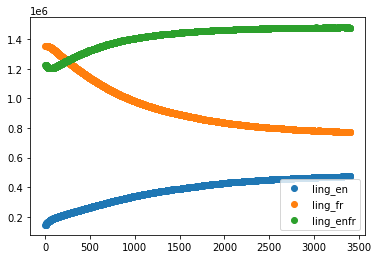

In [407]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=[0, 2], figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

In [ ]:
fig_save_path = save_path_format.format(
    cc=cc, params_str=params_str, region=area_name, cell_size=cell_size, grp='bi_evol_')
idx_data_to_plot = np.arange(0, len(x_data), 1)
ax = sim_viz.time_evol_ling(
    ling_props_dict, x_data, idx_data_to_plot=idx_data_to_plot,
    idx_ling_to_plot=None, figsize=(8,6), bottom_ylim=0,
    fig_save_path=None, show=True)

# Tests

In [741]:
list_lings = ['ling_B']*90 + ['ling_A']*10 + ['ling_A']*100*99
list_res = []
for i in range(100):
    list_res.extend([i]*100)
list_work = [0]*60 + [1]*10 + [2]*10 + [3]*10 + [4]*10
for i in range(1,5):
    list_work.extend([i]*90 + [0]*10)
for i in range(95):
    list_work.extend([i+6]*100)
test_user_df = pd.DataFrame({'ling': list_lings, 'res_cell_id': list_res, 'work_cell_id': list_work})

In [742]:
LOGGER = logging.getLogger(__name__)
LOGGER.info(test_user_df.groupby('ling').size())
t_steps = 20
cell_res = test_user_df.groupby('res_cell_id').size()
cell_workers = test_user_df.groupby('work_cell_id').size()
lings = ['ling_A', 'ling_B', 'ling_AB']
mono_A_mask = test_user_df['ling'] == lings[0]
mono_B_mask = test_user_df['ling'] == lings[1]
sigma_A, sigma_B, global_sigma_A, global_sigma_B = lang_abm.get_sigmas(
    test_user_df, mono_A_mask, mono_B_mask, cell_res)
res_prestige_A = lang_abm.get_prestige(
    sigma_A, sigma_B, global_sigma_A, global_sigma_B)
sigma_A, sigma_B, global_sigma_A, global_sigma_B = lang_abm.get_sigmas(
    test_user_df, mono_A_mask, mono_B_mask, cell_workers)
work_prestige_A = lang_abm.get_prestige(
    sigma_A, sigma_B, global_sigma_A, global_sigma_B)

t_0 = len(hist_cell_df)
for t in range(t_steps):
    LOGGER.info(f'* step {t+t_0} *') 
    # at home
    test_user_df = lang_abm.model_step_wrapper(
        test_user_df, cell_res, lang_abm.bimodel_step, lings,
        prestige_A=res_prestige_A)
    LOGGER.info(test_user_df.groupby('ling').size())
    test_user_df = lang_abm.model_step_wrapper(
        test_user_df, cell_workers, lang_abm.bimodel_step, lings,
        prestige_A=work_prestige_A)
    LOGGER.info(test_user_df.groupby('ling').size())

2020-05-26 12:18:10,793 - __main__ - INFO - ling
ling_A    9910
ling_B      90
dtype: int64
2020-05-26 12:18:10,847 - __main__ - INFO - ling
ling_A     9901
ling_AB       9
ling_B       90
dtype: int64
2020-05-26 12:18:10,880 - __main__ - INFO - ling
ling_A     9892
ling_AB      46
ling_B       62
dtype: int64
2020-05-26 12:18:10,912 - __main__ - INFO - ling
ling_A     9906
ling_AB      12
ling_B       82
dtype: int64
2020-05-26 12:18:10,944 - __main__ - INFO - ling
ling_A     9903
ling_AB      33
ling_B       64
dtype: int64
2020-05-26 12:18:10,978 - __main__ - INFO - ling
ling_A     9905
ling_AB      13
ling_B       82
dtype: int64
2020-05-26 12:18:11,011 - __main__ - INFO - ling
ling_A     9905
ling_AB      41
ling_B       54
dtype: int64
2020-05-26 12:18:11,043 - __main__ - INFO - ling
ling_A     9909
ling_AB      13
ling_B       78
dtype: int64
2020-05-26 12:18:11,075 - __main__ - INFO - ling
ling_A     9901
ling_AB      47
ling_B       52
dtype: int64
2020-05-26 12:18:11,107 - __